In [1]:
install.packages("Ckmeans.1d.dp") 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
### Libraries ###
suppressMessages({
    library(tictoc)
    library(caret)
    library(xgboost)
    library(magrittr)
    library(janitor)
    library(ggthemes)
    library(parallel)
    library(tidyverse) 
    library(lubridate)
    library(data.table)
    library(Ckmeans.1d.dp) # Feature Importance
})

In [3]:
detectCores()

[1] 4

In [4]:
options(repr.plot.width = 14 * 1.5, repr.plot.height = 8 * 1.2)
set.seed(42)

<h1 style = "color:blue">Lectura y Procesamiento</h1>

In [5]:
# Quick Visualization
quick_viz <- function(df, cases) {
    ggplot(data = df, aes(x = df$date, y = df$cases)) +
        geom_area(color = "blue", alpha = 0.3) +
        theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom") +
        ggtitle("Número de Casos por Fecha")
}

In [6]:
quick_viz_res_line <- function(cases) {
    ggplot(df, aes(x = date)) +
        geom_line(aes_string(y = cases), color = "blue") +
        geom_line(aes(y = Preds), color = "red") +
        theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom") +
        ggtitle("Número de Casos por Preds")
}

In [7]:
quick_viz_res_area <- function(df, cases) {
    ggplot(df, aes(x = date)) +
        geom_area(aes_string(y = cases), color = "blue") +
        geom_area(aes(y = Preds), color = "red") +
        theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom") +
        ggtitle("Número de Casos por Preds")
}

<h3 style= "color:red">Afganistan</h3>

In [8]:
df_afganistan <- read.table("../input/covid19-data/Countries/Countries/Afganistan/data.csv",
                         sep = ',', fill = TRUE, header = T)
#df_afganistan

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“embedded nul(s) found in input”


In [9]:
df_afganistan %<>% arrange(ymd(df_afganistan$Date)) %>%
    mutate(
        Date = ymd(df_afganistan$Date),
        Tests = ymd(df_afganistan$Tests)
    ) %>%
    clean_names()
head(df_afganistan, 3)

Warning message:
“ 1004635 failed to parse.”
Warning message:
“ 1004635 failed to parse.”
Warning message:
“All formats failed to parse. No formats found.”


,province,cases,deaths,recoveries,active_cases,tests,date
,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<date>
1,Algeria,,https://www.dzairdaily.com/algerie-premier-cas-coronavirus-alger-italien-virus,,,NA,2021-05-05
2,Algeria,Dead,https://www.algerie-eco.com/2020/03/02/le-ministere-de-la-sante-annonce-deux-cas-confirmes-de-coronavirus-a-blida/,,,NA,2021-05-05
3,Algeria,Recovered,https://www.algerie-eco.com/2020/03/02/le-ministere-de-la-sante-annonce-deux-cas-confirmes-de-coronavirus-a-blida/,,,NA,2021-05-05


In [10]:
max(df_afganistan$date, na.rm = T)

[1] "2021-05-05"

In [11]:
min(df_afganistan$date, na.rm = T)

[1] "2020-02-25"

In [12]:
df_afganistan <- df_afganistan[df_afganistan$date >= "2020-02-25" & df_afganistan$date <= "2021-05-05", ]

tail(df_afganistan, 5)

,province,cases,deaths,recoveries,active_cases,tests,date
,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<date>
NA.1708798,NA,NA,NA,NA,NA,NA,NA
NA.1708799,NA,NA,NA,NA,NA,NA,NA
NA.1708800,NA,NA,NA,NA,NA,NA,NA
NA.1708801,NA,NA,NA,NA,NA,NA,NA
NA.1708802,NA,NA,NA,NA,NA,NA,NA


In [13]:
df_afganistan %>% dim()
#df_afganistan %>% tail()

[1] 1716835       7

<h3 style= "color:red">Canada</h3>

In [14]:
df_canada <- suppressWarnings(fread("../input/covid19-data/Countries/Countries/canada/cases.saskechuan.csv")) 
    
df_canada %<>% mutate(Date = ymd(df_canada$Date)) %>% 
    clean_names() %>%
    rename(
        cases_cd = new_cases,
        recovered_cd = recovered_cases,
        deaths_cd = deaths
    )
head(df_canada, 5)

date,region,cases_cd,total_cases,active_cases,inpatient_hospitalizations,icu_hospitalizations,recovered_cd,deaths_cd
<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2020-08-04,Far North West,0,346,4,0,0,335,7
2020-08-04,Far North West,0,NA,0,NA,NA,NA,NA
2020-08-04,Far North Central,0,0,0,0,0,0,0
2020-08-04,Far North East,0,6,0,0,0,6,0
2020-08-04,Far North East,0,NA,0,NA,NA,NA,NA


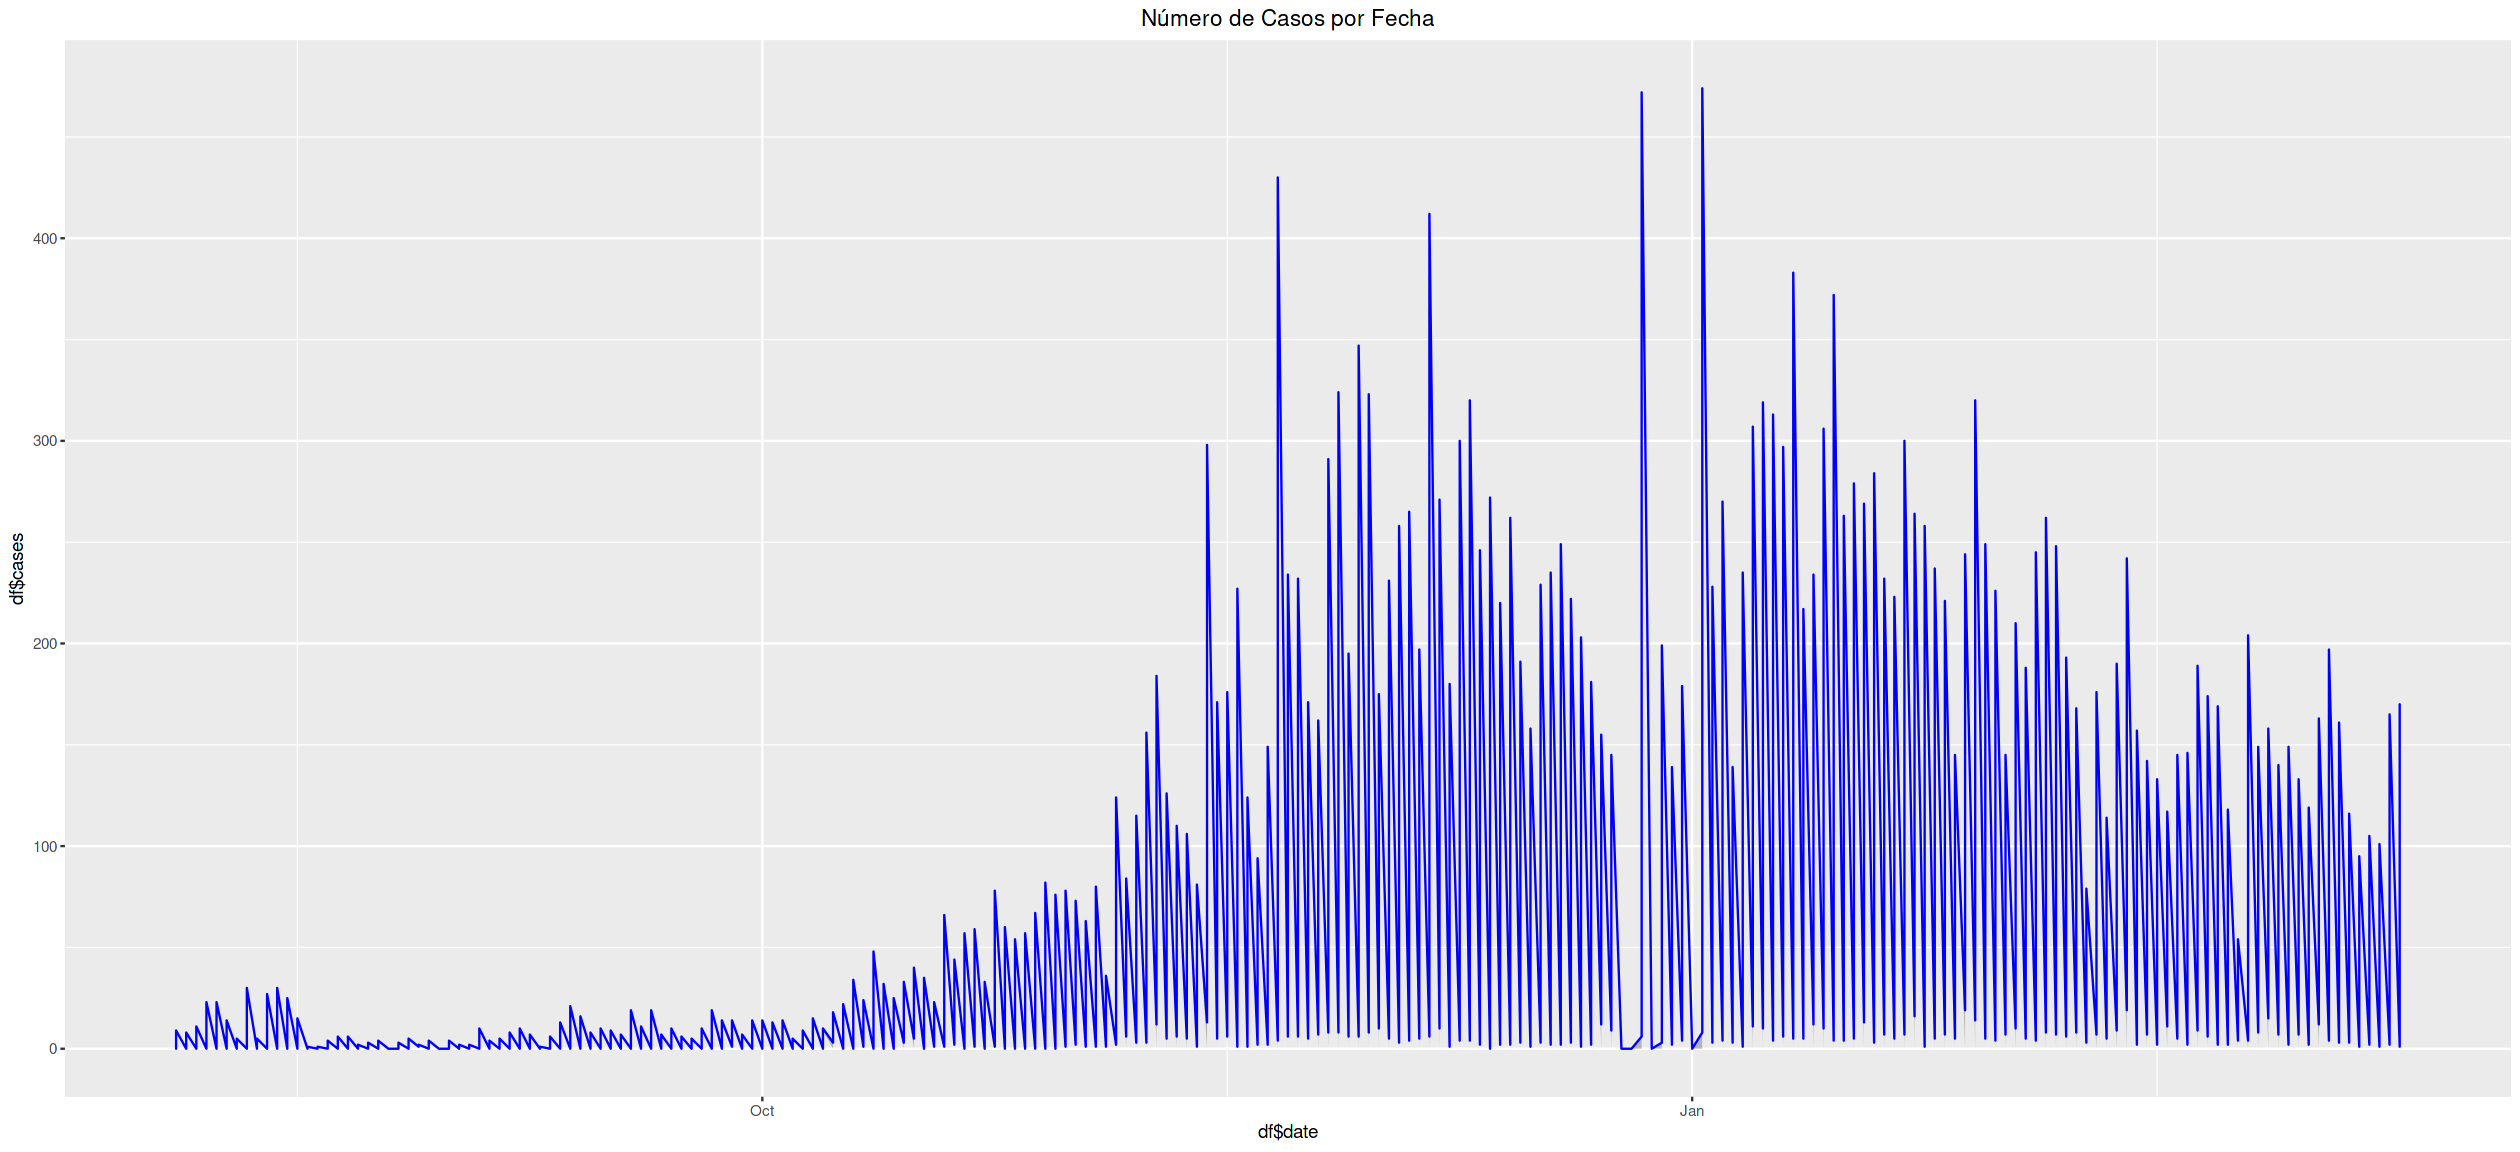

In [15]:
quick_viz(df_canada, cases_cd)

<h3 style= "color:red">India</h3>

In [16]:
df_india <- fread("../input/covid19-data/Countries/Countries/india/districts.csv", stringsAsFactors = F) 
    
df_india %<>% clean_names() %>%
    rename(
        cases_in = confirmed, 
        deaths_in = deceased,
        recovered_in = recovered
    ) 

head(df_india, 5)

Warning message in fread("../input/covid19-data/Countries/Countries/india/districts.csv", :
“Stopped early on line 238946. Expected 8 fields but found 7. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<PKQa<e0><8c><cd>s<bc>>>”


date,state,district,cases_in,recovered_in,deaths_in,other,tested
<date>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
2020-04-26,Andaman and Nicobar Islands,Unknown,33,11,0,0,2679
2020-04-26,Andhra Pradesh,Anantapur,53,14,4,0,NA
2020-04-26,Andhra Pradesh,Chittoor,73,13,0,0,NA
2020-04-26,Andhra Pradesh,East Godavari,39,12,0,0,NA
2020-04-26,Andhra Pradesh,Guntur,214,29,8,0,NA


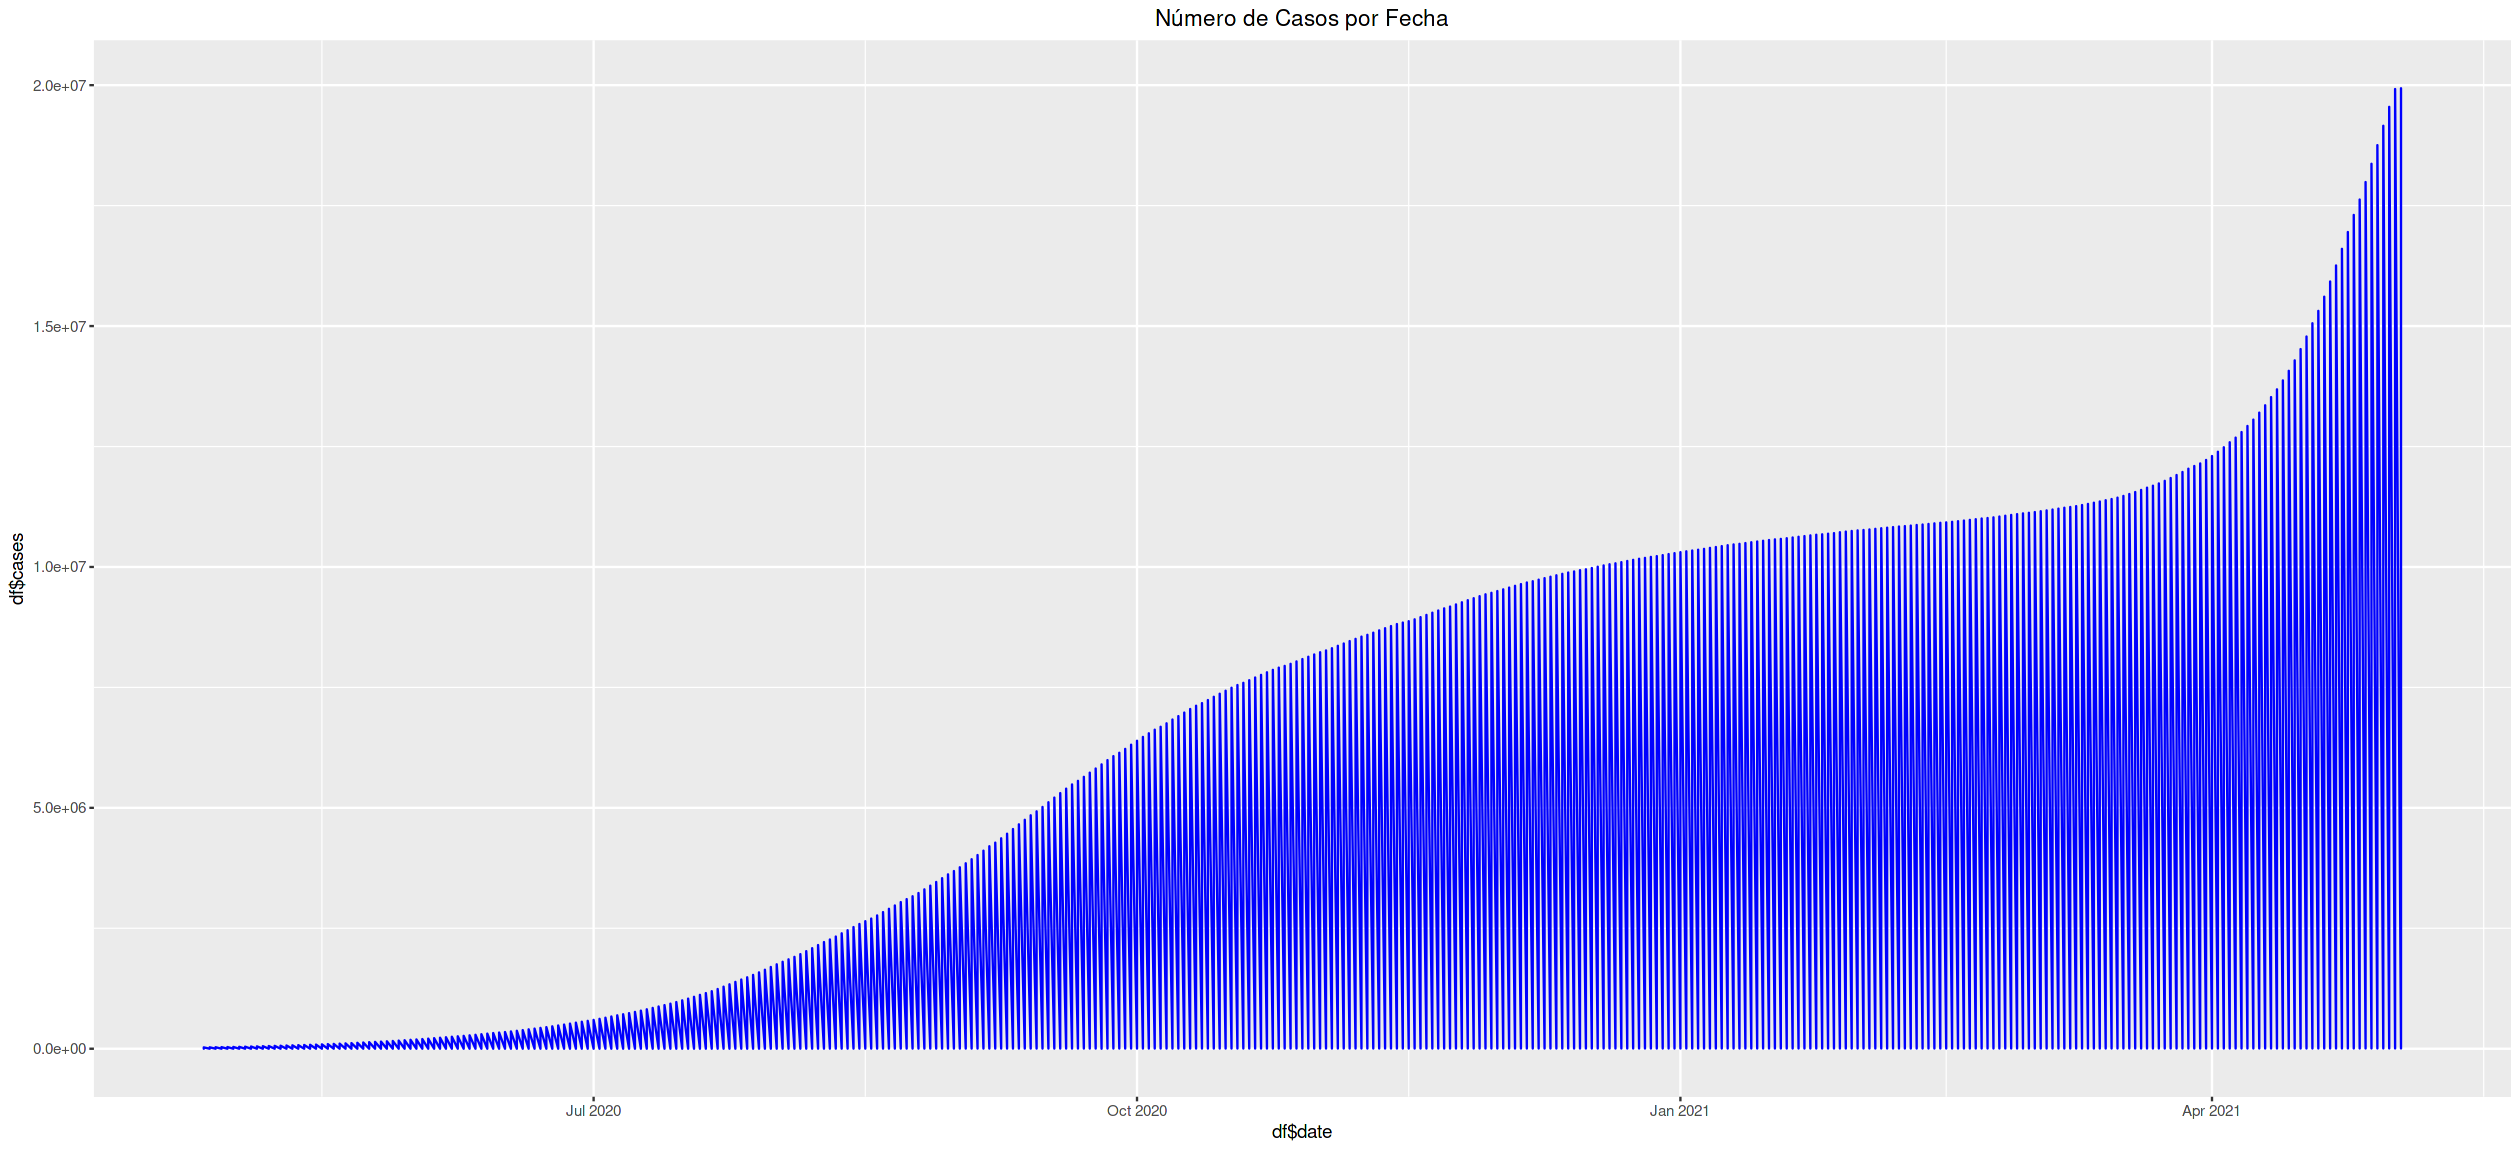

In [17]:
quick_viz(df_india, cases_in)

<h3 style= "color:red">Gran Bretaña</h3>

In [18]:
df_gb <- suppressWarnings(fread("../input/covid19-data/Countries/Countries/GB/data_2021-05-02.csv", stringsAsFactors = F))

df_gb %<>% clean_names() %>%
    rename(
        cases_gb = new_cases_by_specimen_date,
        deaths_gb = new_deaths_by_death_date
    ) %>% relocate(date, .before = area_code) %>% 
    drop_na() 
head(df_gb, 5)

date,area_code,area_name,area_type,cases_gb,deaths_gb
<date>,<chr>,<chr>,<chr>,<int>,<int>
2021-05-01,E06000003,Redcar and Cleveland,ltla,0,0
2021-05-01,E07000040,East Devon,ltla,1,0
2021-05-01,E07000090,Havant,ltla,0,0
2021-05-01,E07000214,Surrey Heath,ltla,1,0
2021-05-01,E07000229,Worthing,ltla,1,0


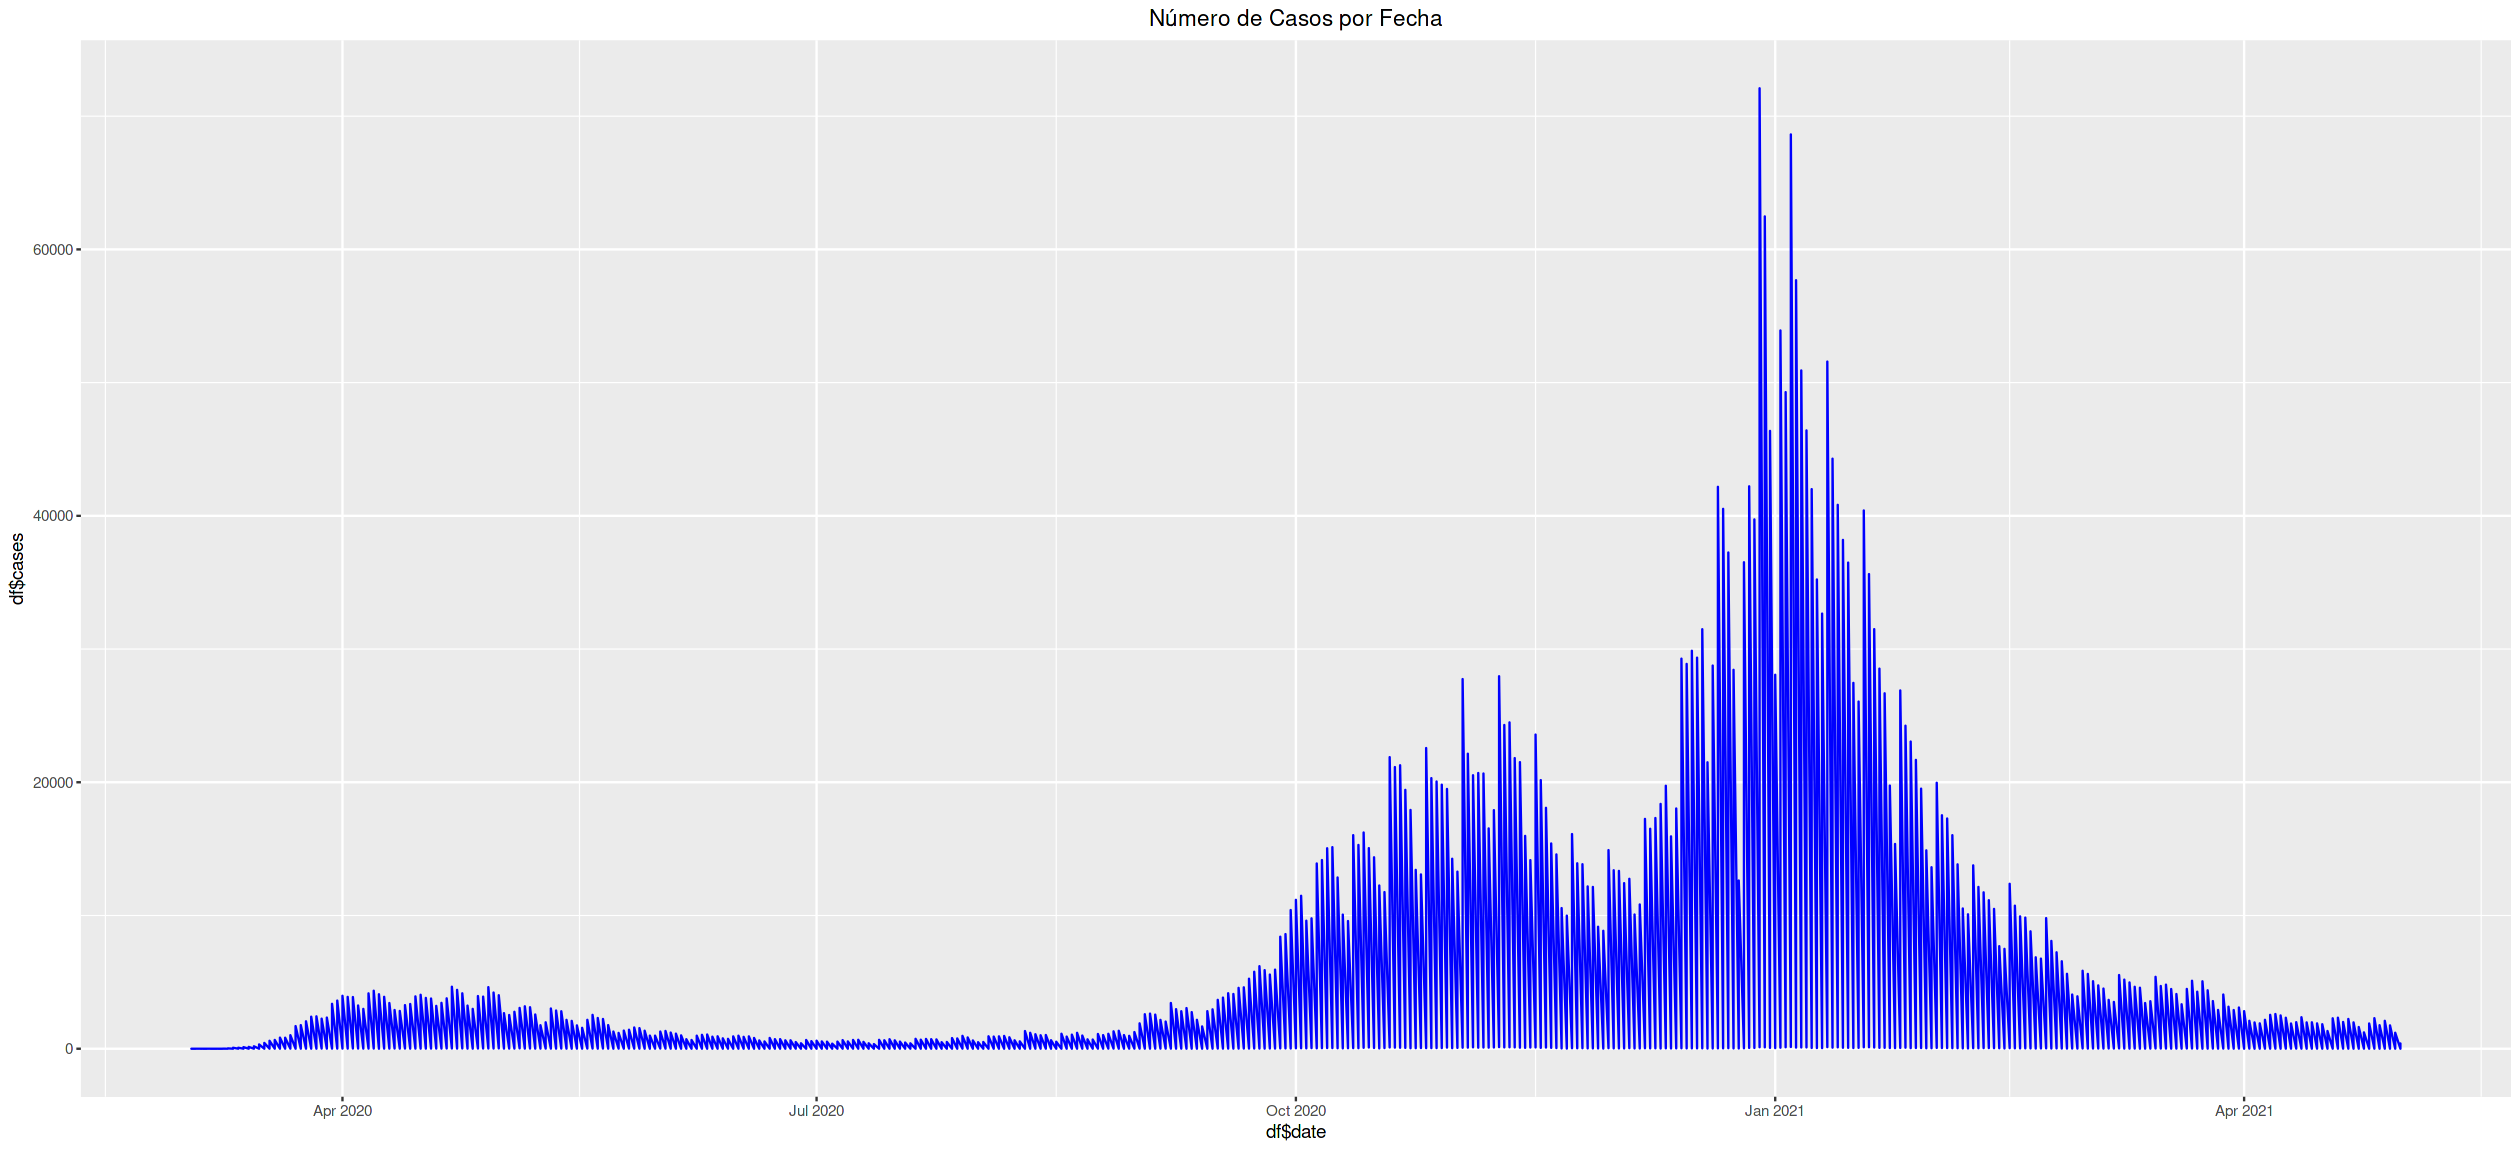

In [19]:
quick_viz(df_gb, cases_gb)

<h3 style= "color:red">España</h3>

In [20]:
df_spain <- fread("../input/covid19-data/Countries/Countries/spain/provincias_covid19_datos_isciii_nueva_serie.csv",
                  stringsAsFactors = F)

df_spain %<>% mutate(fecha = ymd(df_spain$fecha)) %>%
    mutate_at(vars(matches("num")), as.numeric) %>%
    rename(
        cases_sp = num_casos,
        date = fecha
    ) %>%
    relocate(cod_ine, .after = provincia) 
head(df_spain, 5)

Warning message in fread("../input/covid19-data/Countries/Countries/spain/provincias_covid19_datos_isciii_nueva_serie.csv", :
“Stopped early on line 26004. Expected 9 fields but found 10. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<2021-01-03,1609646400,114230,147,108268,182,1034,2,4928PK<fa><ef>Ӵt;>>”
Warning message:
“ 1 failed to parse.”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


date,provincia,cod_ine,cases_sp,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-01,Alicante/Alacant,03,0,0,0,0,0,0
2020-01-02,Alicante/Alacant,03,0,0,0,0,0,0
2020-01-03,Alicante/Alacant,03,0,0,0,0,0,0
2020-01-04,Alicante/Alacant,03,0,0,0,0,0,0
2020-01-05,Alicante/Alacant,03,0,0,0,0,0,0


Warning message:
“Removed 1 rows containing missing values (position_stack).”


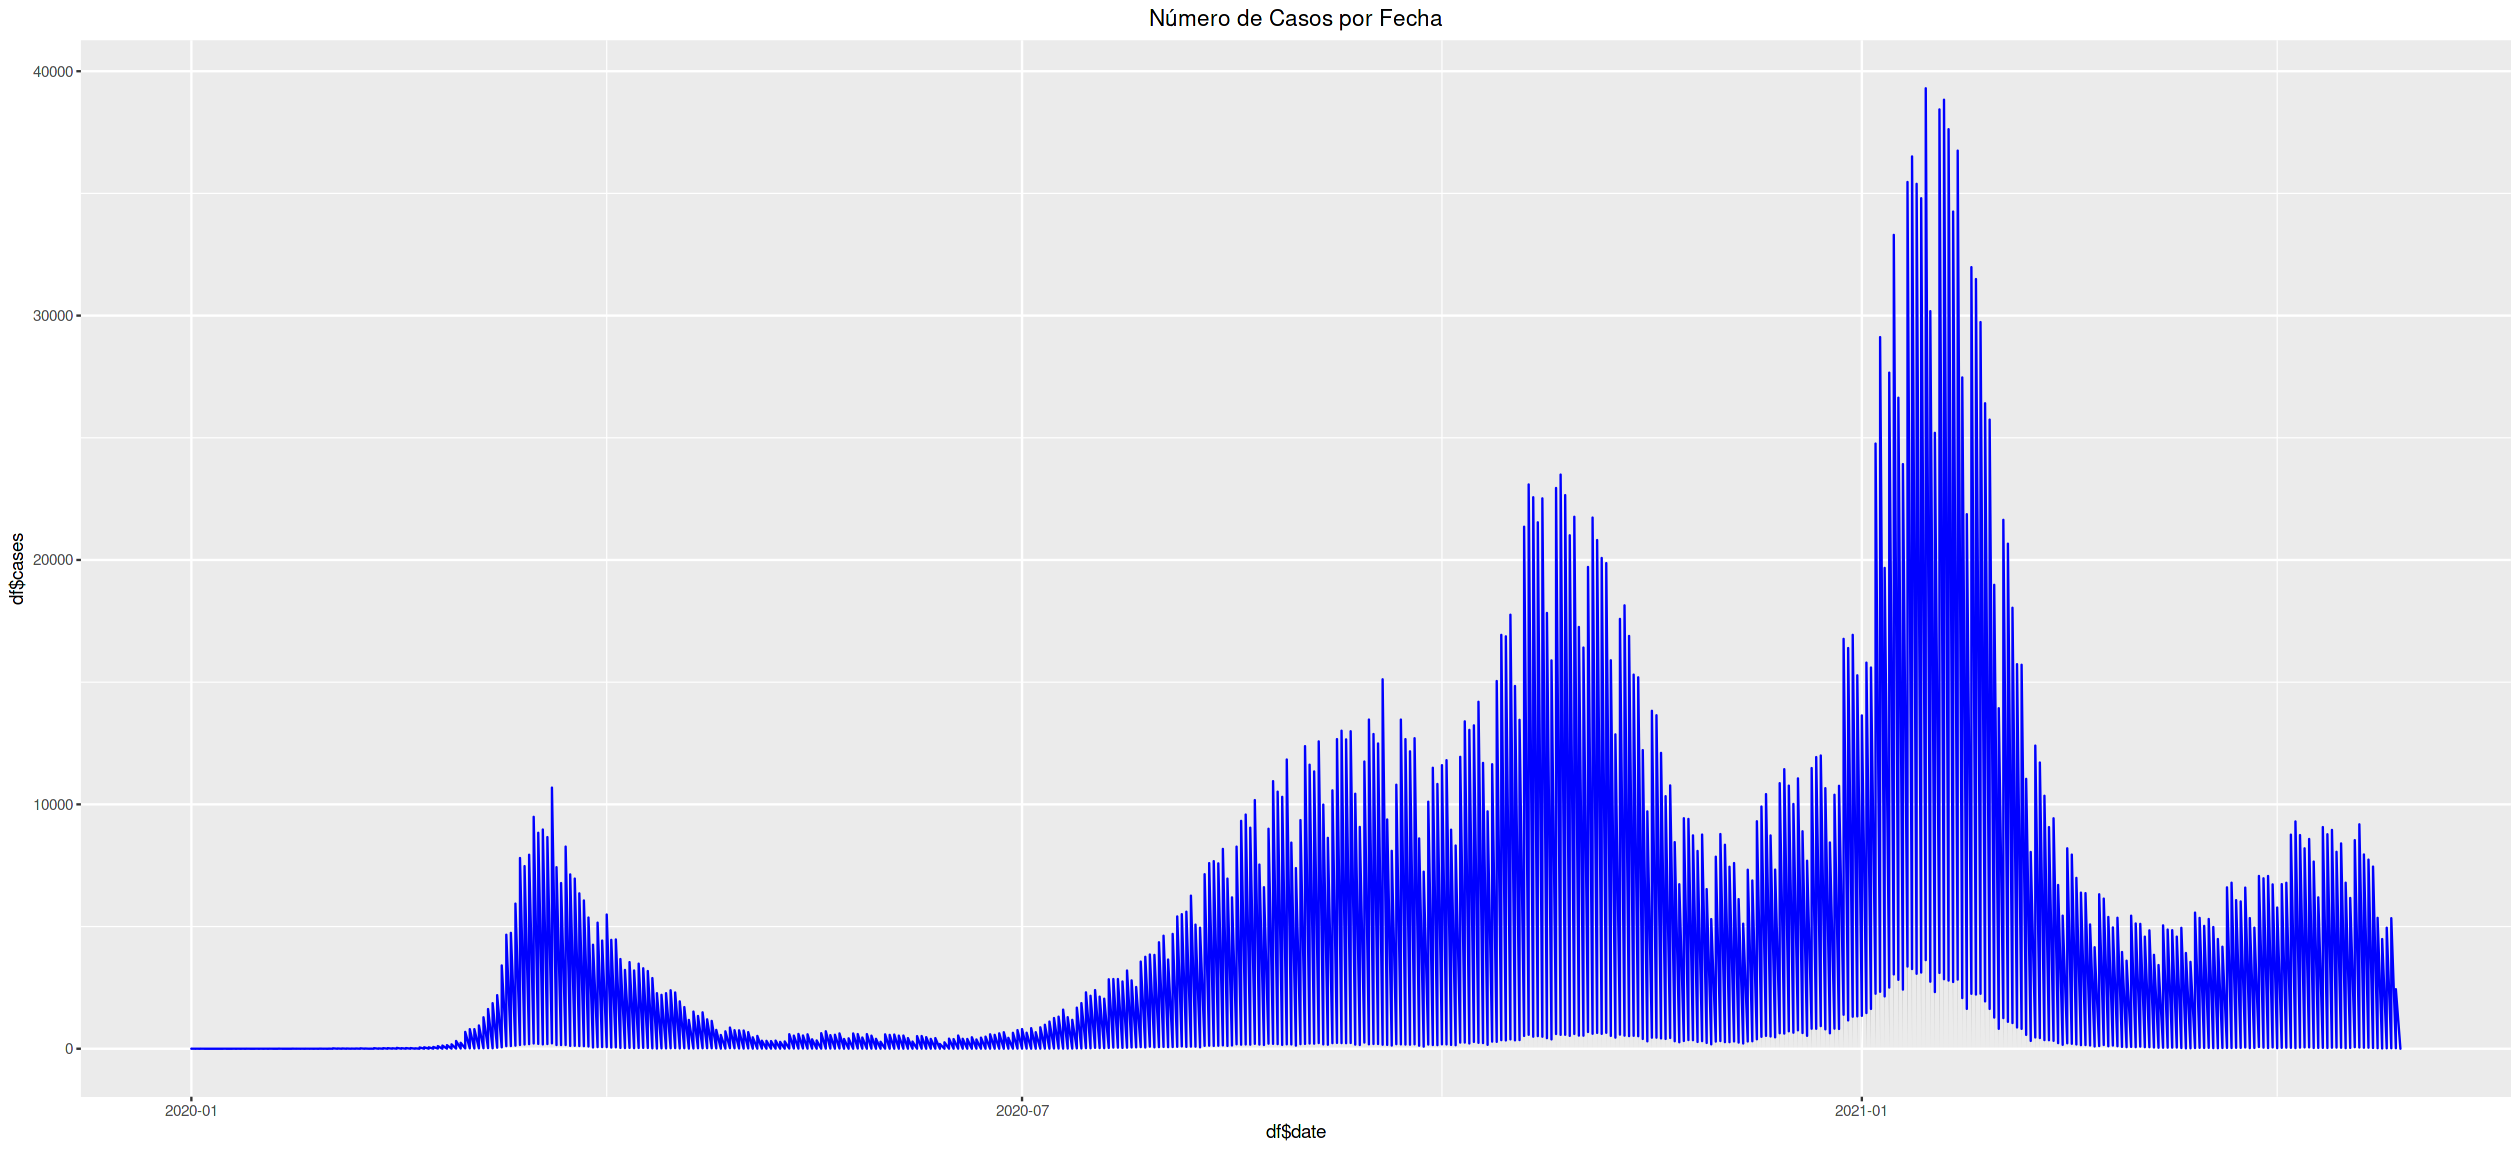

In [21]:
quick_viz(df_spain, cases_sp)

<h1 style = "color:blue">Particionamiento de Datos</h1>

In [22]:
train_cd <- df_canada[date >= "2020-08-04" & date <= "2021-02-11", ]
test_cd <- df_canada[date >= "2021-02-12" & date <= "2021-03-12", ]

In [23]:
train_in <- df_india[date >= "2020-04-26" & date <= "2021-04-02", ]
test_in <- df_india[date >= "2021-04-03" & date <= "2021-05-03", ]

In [24]:
train_gb <- df_gb[date >= "2020-01-30" & date <= "2021-03-31", ]
test_gb <- df_gb[date >= "2021-04-01" & date <= "2021-05-01", ]

In [25]:
train_sp <- df_spain[date >= "2020-01-01" & date <= "2021-03-28", ]
test_sp <- df_spain[date >= "2021-03-29" & date <= "2021-04-29", ]

<h1 style= "color:blue">XGBoost</h1>



In [26]:
# Cross-validation
xgb_tr_control <- trainControl(
    method = "cv",
    number = 10,
    allowParallel = T,
    verboseIter = F,
    returnData = F
)

#Building parameters set
xgb_grid <- expand.grid(
  list(
    nrounds = seq(100, 200),
    max_depth = c(6, 15, 20), 
    colsample_bytree = 1, 
    eta = 0.02,
    gamma = 0,
    min_child_weight = 1,  
    subsample = 1)
)

<h2 style= "color:blue">Canada</h2>


<h3 style= "color:red">Agrupados</h3>

In [27]:
train_cd_grouped <- train_cd %>% group_by(date) %>%
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
    )

test_cd_grouped <- test_cd %>% group_by(date) %>% 
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
    )

In [28]:
train_Dmatrix <- train_cd_grouped %>%
    select(-date, -cases_cd) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_cd_grouped %>%
    select(-date, -cases_cd) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_cd_grouped$cases_cd

In [29]:
# Building the model for canada
tic()
xgb_model_cd_grouped <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

12.258 sec elapsed


In [30]:
xgb_model_cd_grouped$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48,147,6,0.02,0,1,1,1


In [31]:
preds <- caret::predict.train(xgb_model_cd_grouped, pred_Dmatrix)
test_cd_grouped$Preds <- preds
df <- bind_rows(train_cd_grouped, test_cd_grouped)

Warning message:
“Removed 192 row(s) containing missing values (geom_path).”


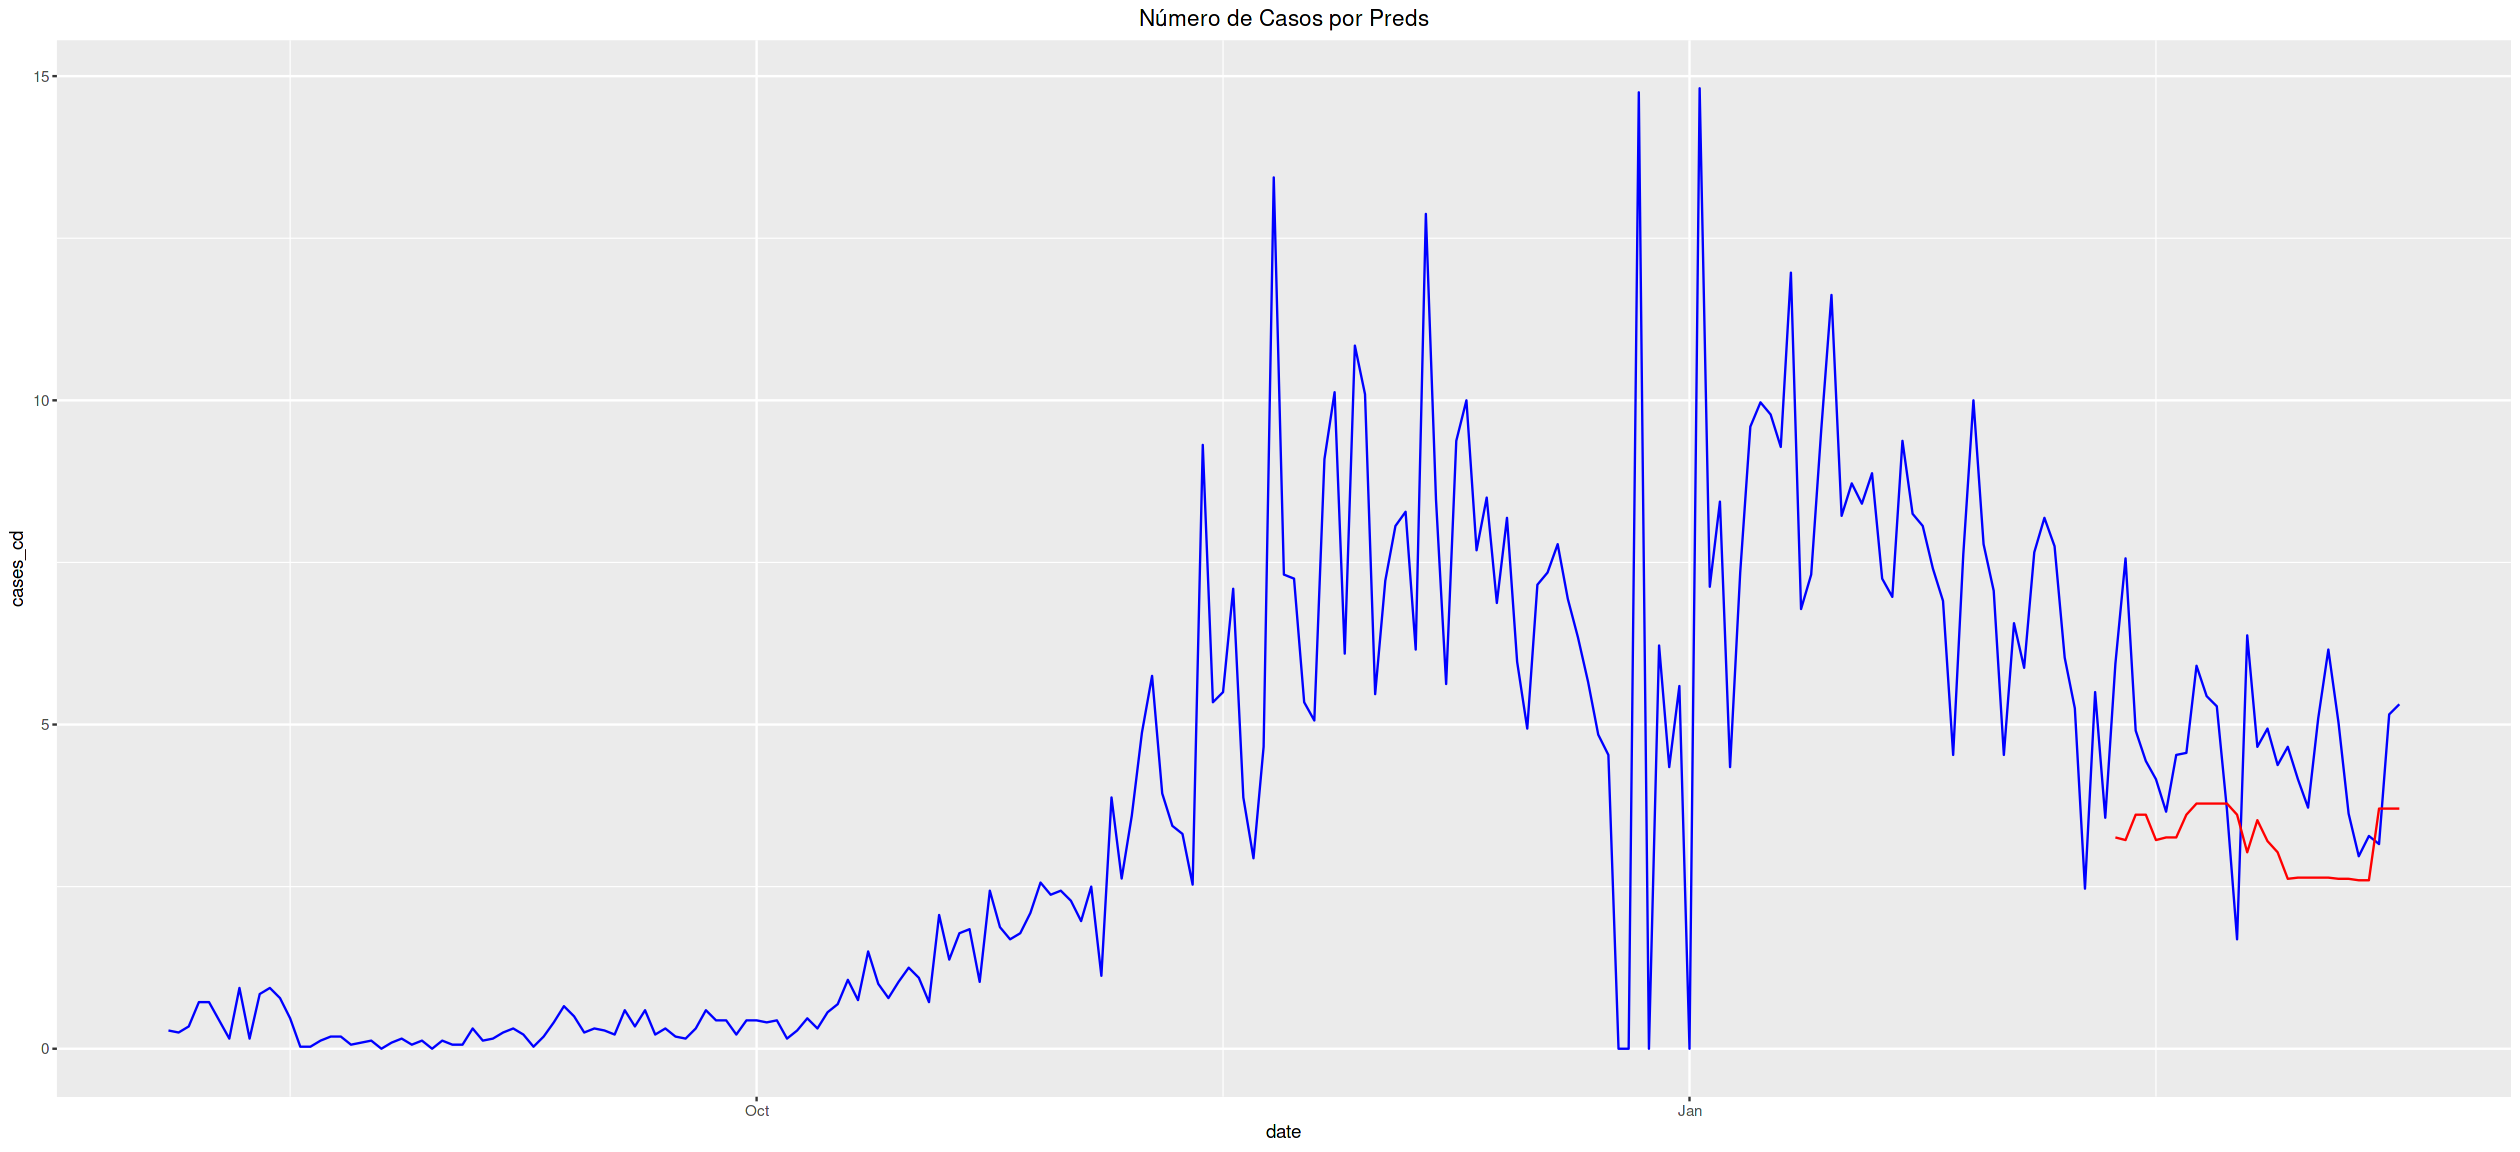

In [32]:
quick_viz_res_line("cases_cd")

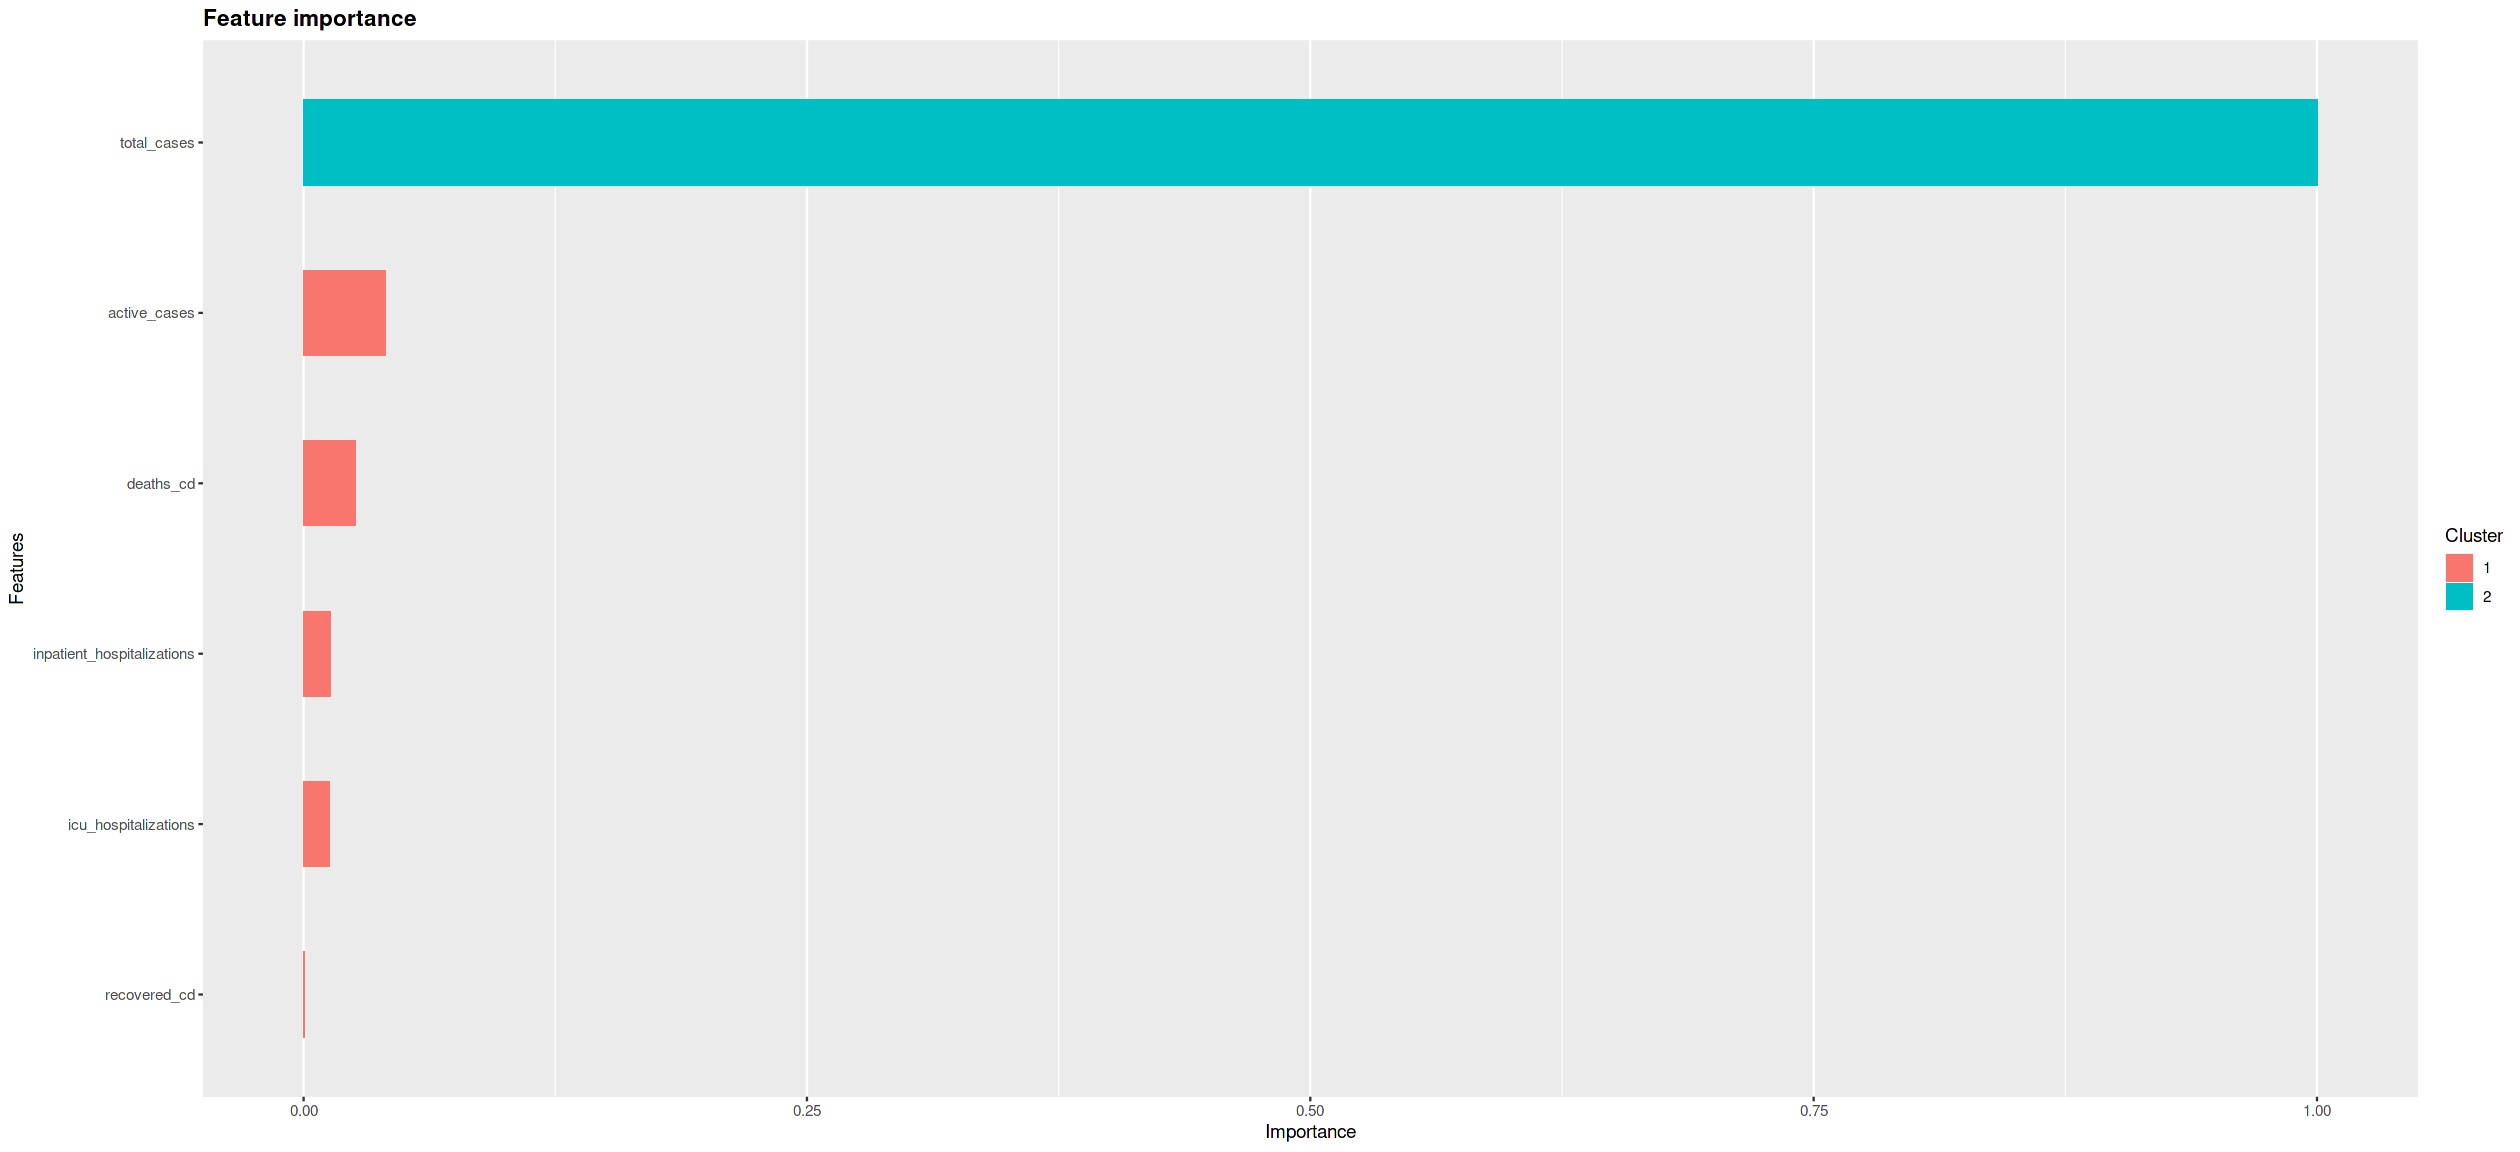

In [33]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_cd_grouped %>% select(-date, -cases_cd)),
    model = xgb_model_cd_grouped$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h3 style= "color:red">No Agrupados</h3>

In [34]:
train_Dmatrix <- train_cd%>%
    select(-c(1:4)) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_cd %>%
    select(-c(1:4)) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_cd$cases_cd

In [35]:
# Building the model for canada
tic()
xgb_model_cd <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

58.19 sec elapsed


In [36]:
xgb_model_cd$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,114,6,0.02,0,1,1,1


In [37]:
preds <- caret::predict.train(xgb_model_cd, pred_Dmatrix)
test_cd$Preds <- preds
df_canada <- bind_rows(train_cd, test_cd)

Warning message:
“Removed 6144 rows containing missing values (position_stack).”


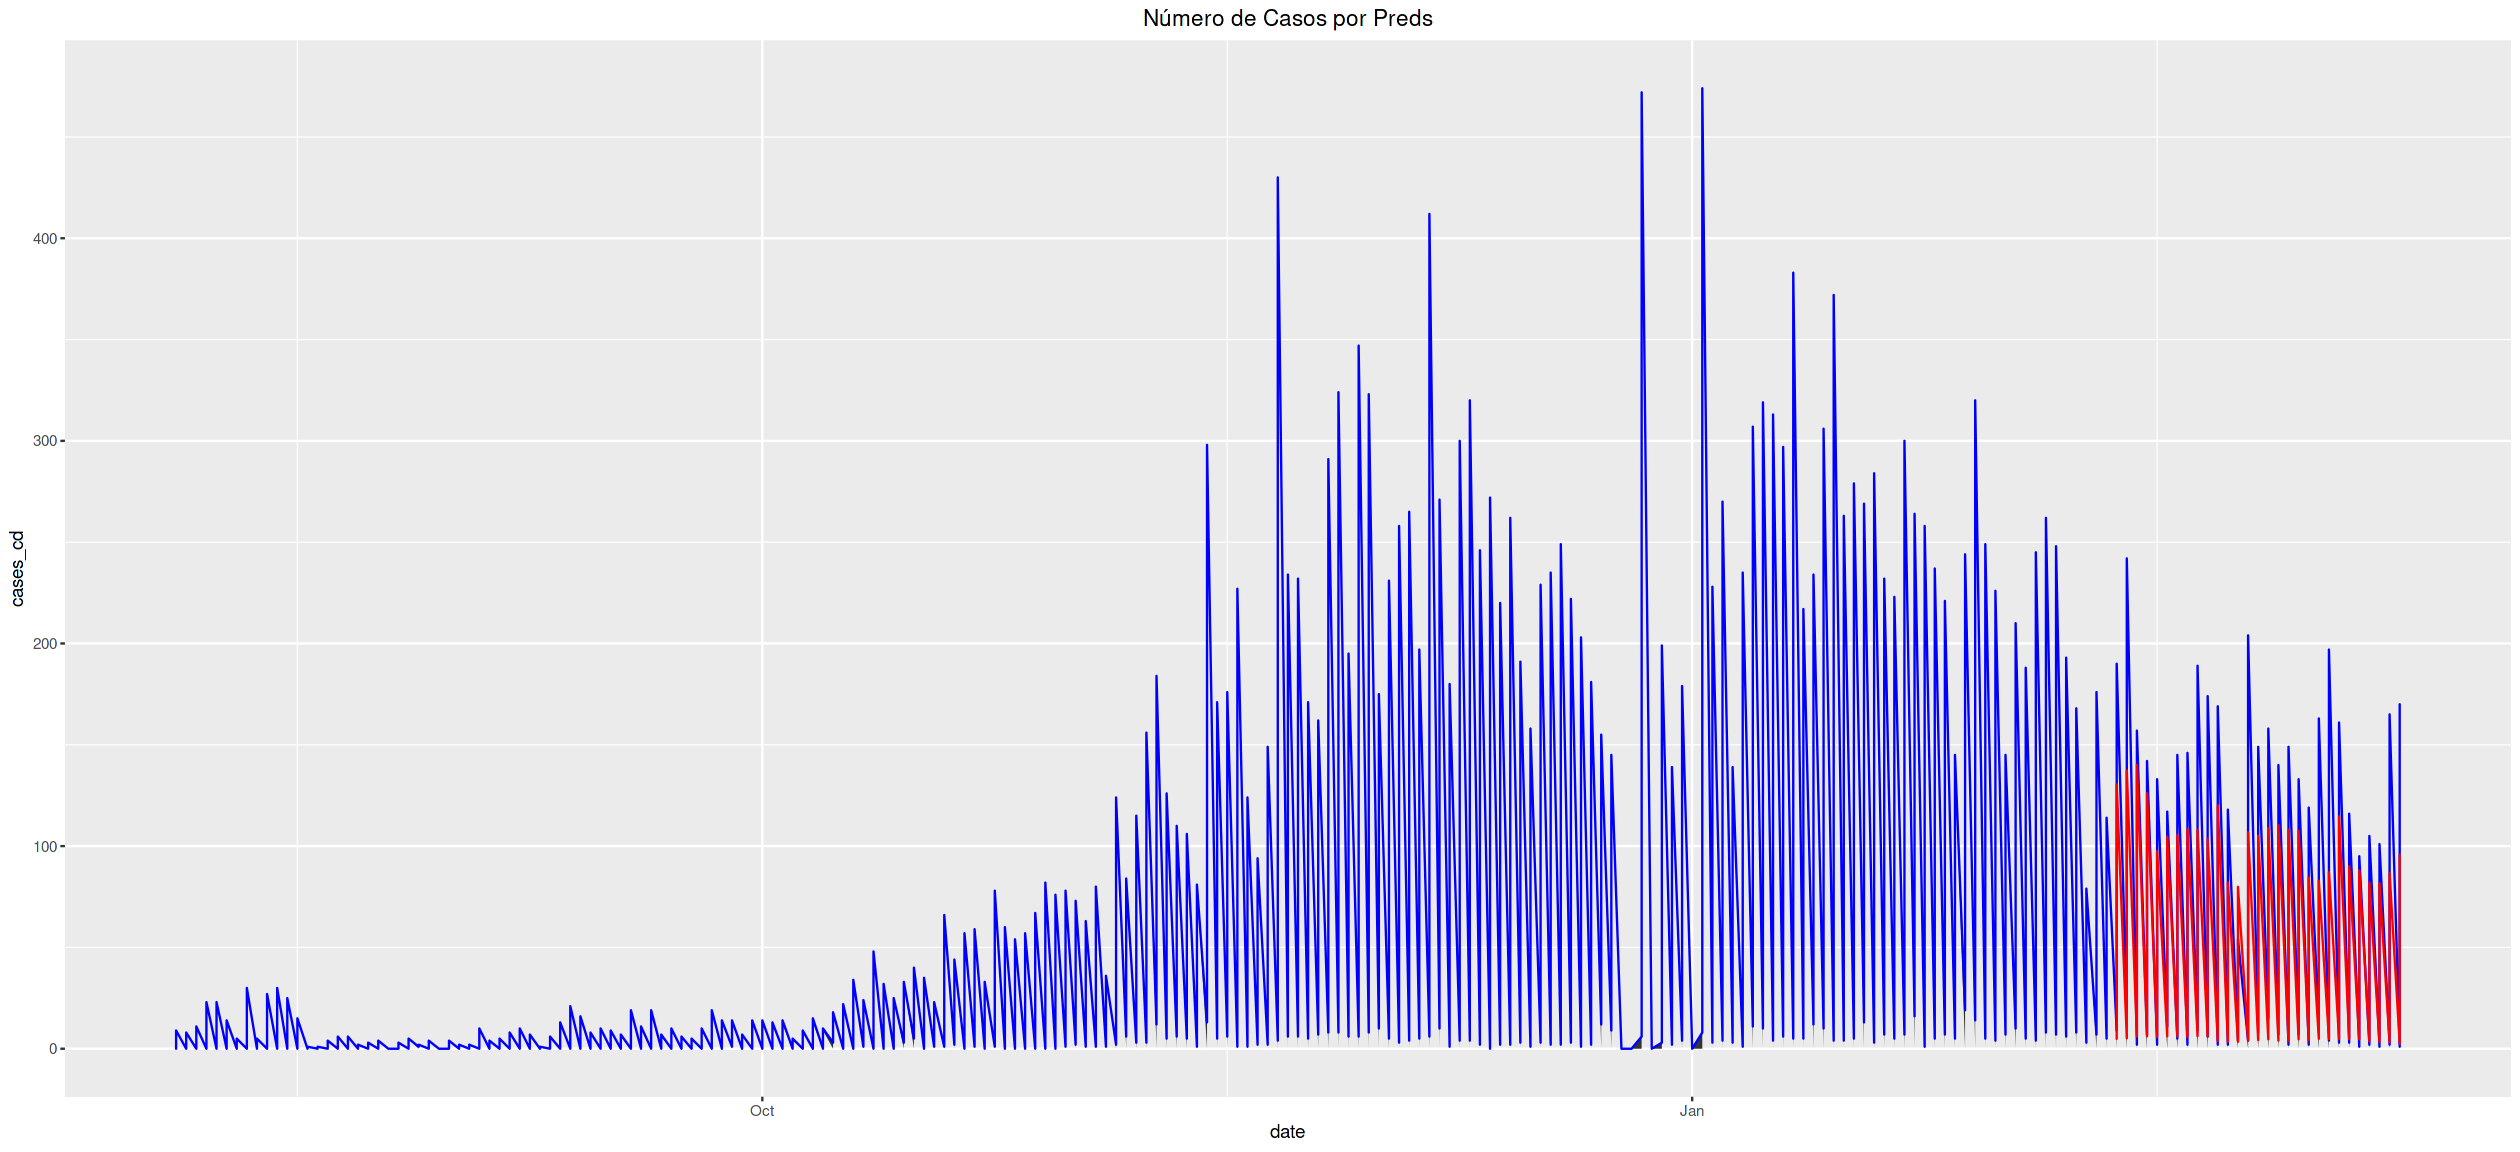

In [38]:
quick_viz_res_area(df_canada, "cases_cd")

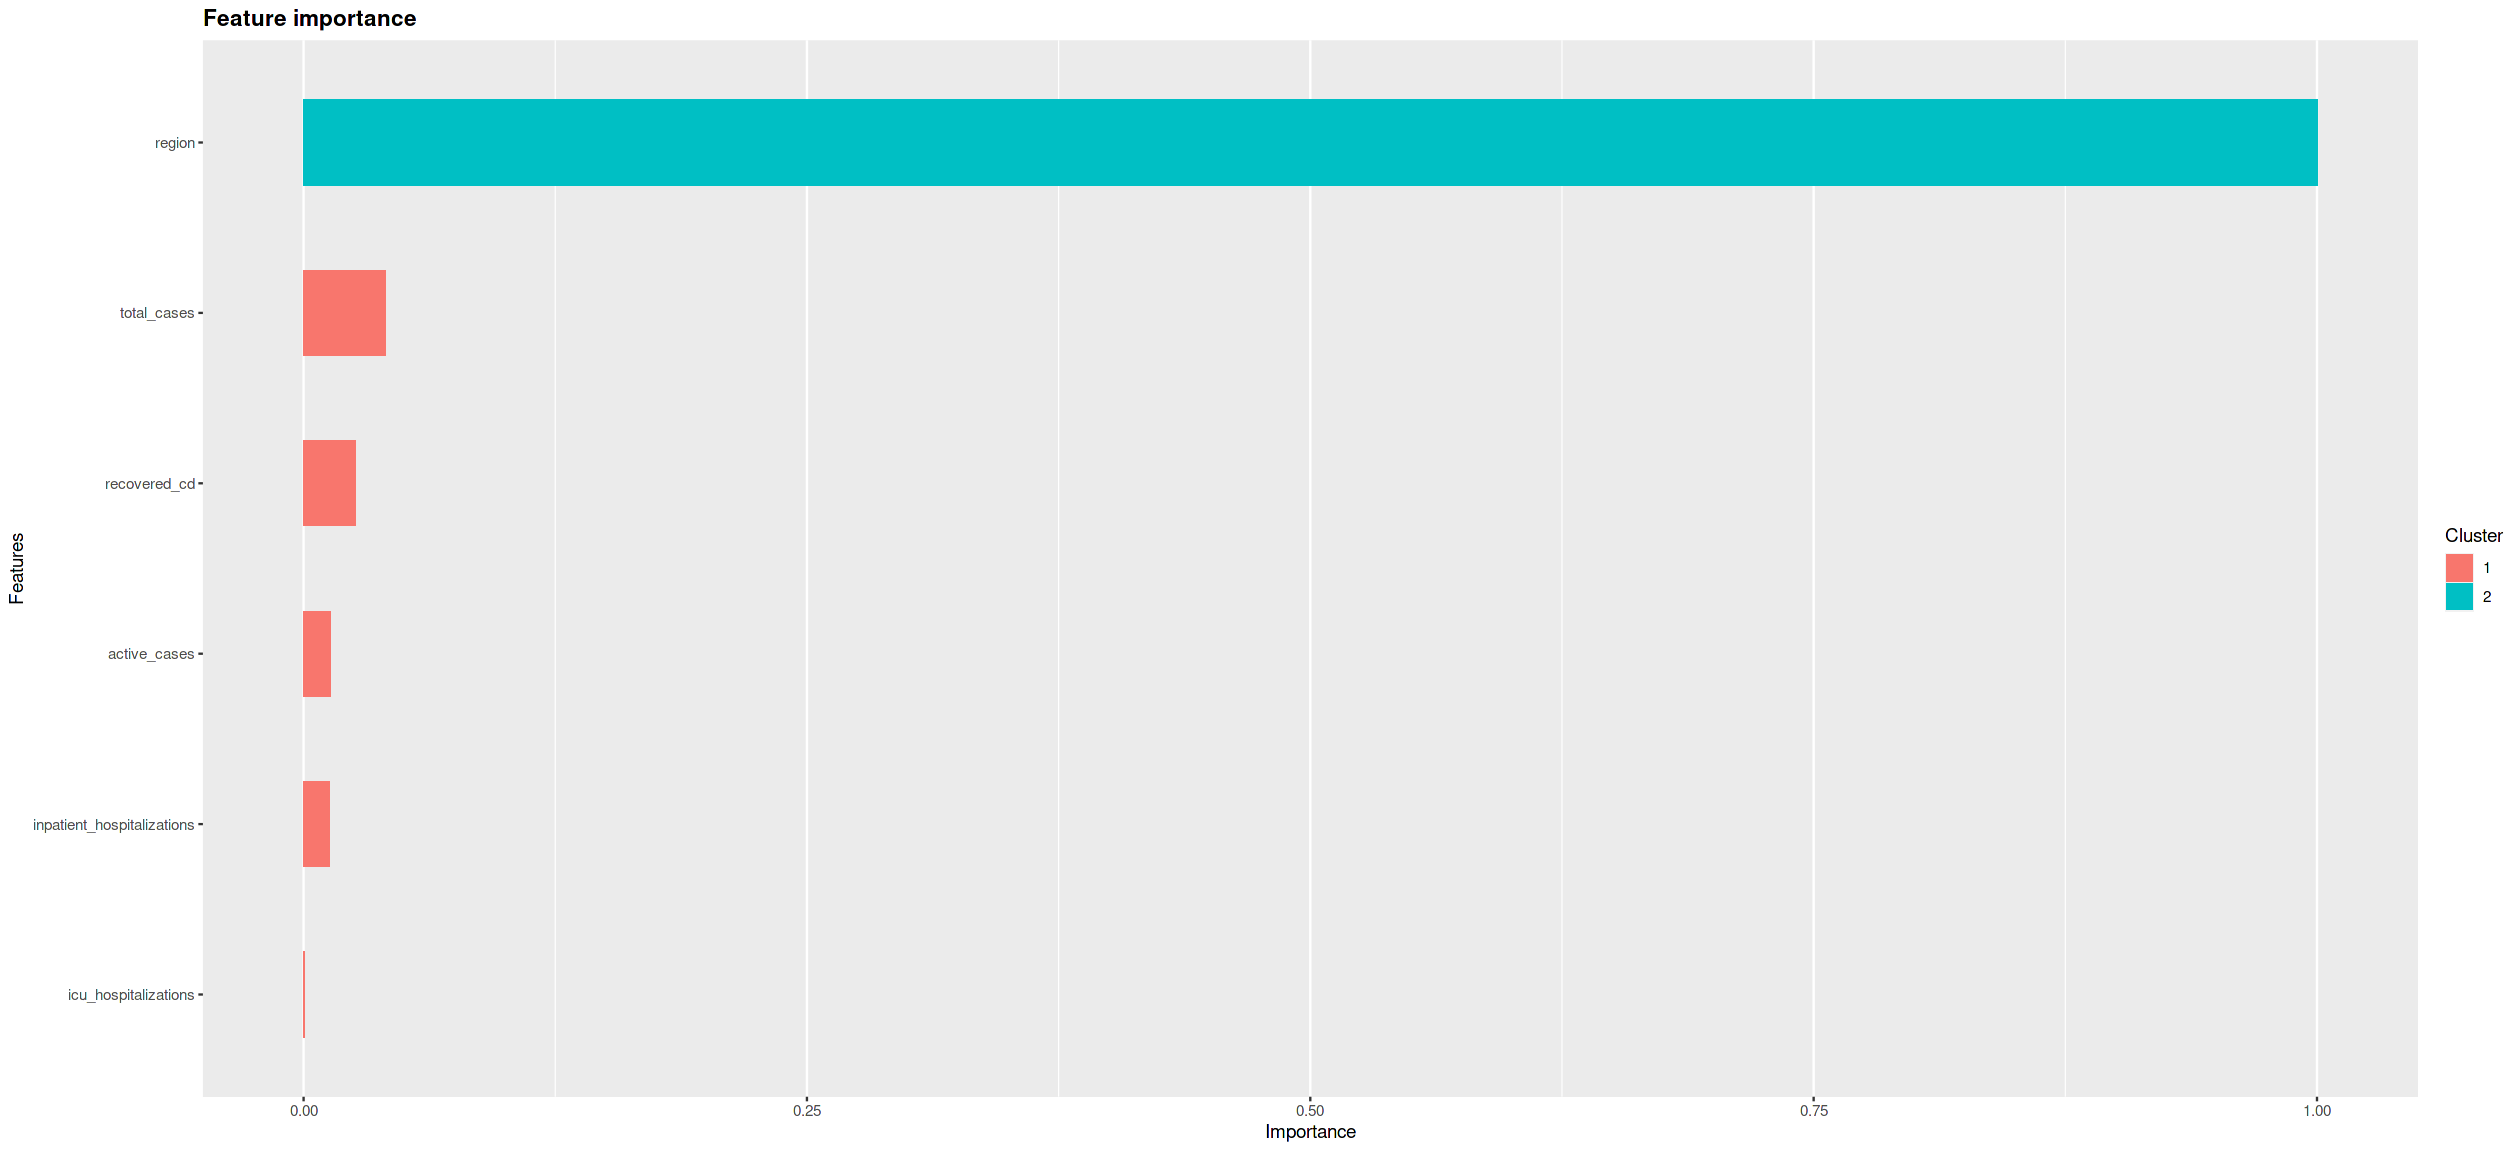

In [39]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_cd %>% select(-date, -cases_cd)),
    model = xgb_model_cd_grouped$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h2 style= "color:blue">India</h2>


<h3 style= "color:red">Agrupados</h3>

In [40]:
train_in_grouped <- train_in %>% group_by(date) %>%
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
    )

test_in_grouped <- test_in %>% group_by(date) %>% 
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
    )

In [41]:
train_Dmatrix <- train_in_grouped %>%
    select(-date, -cases_in) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_in_grouped %>%
    select(-date, -cases_in) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_in_grouped$cases_in

In [42]:
# Building the model for india
tic()
xgb_model_in_grouped <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

8.335 sec elapsed


In [43]:
xgb_model_in_grouped$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
202,200,15,0.02,0,1,1,1


In [44]:
preds <- caret::predict.train(xgb_model_in_grouped, pred_Dmatrix)
test_in_grouped$Preds <- preds
df <- bind_rows(train_in_grouped, test_in_grouped)

Warning message:
“Removed 342 row(s) containing missing values (geom_path).”


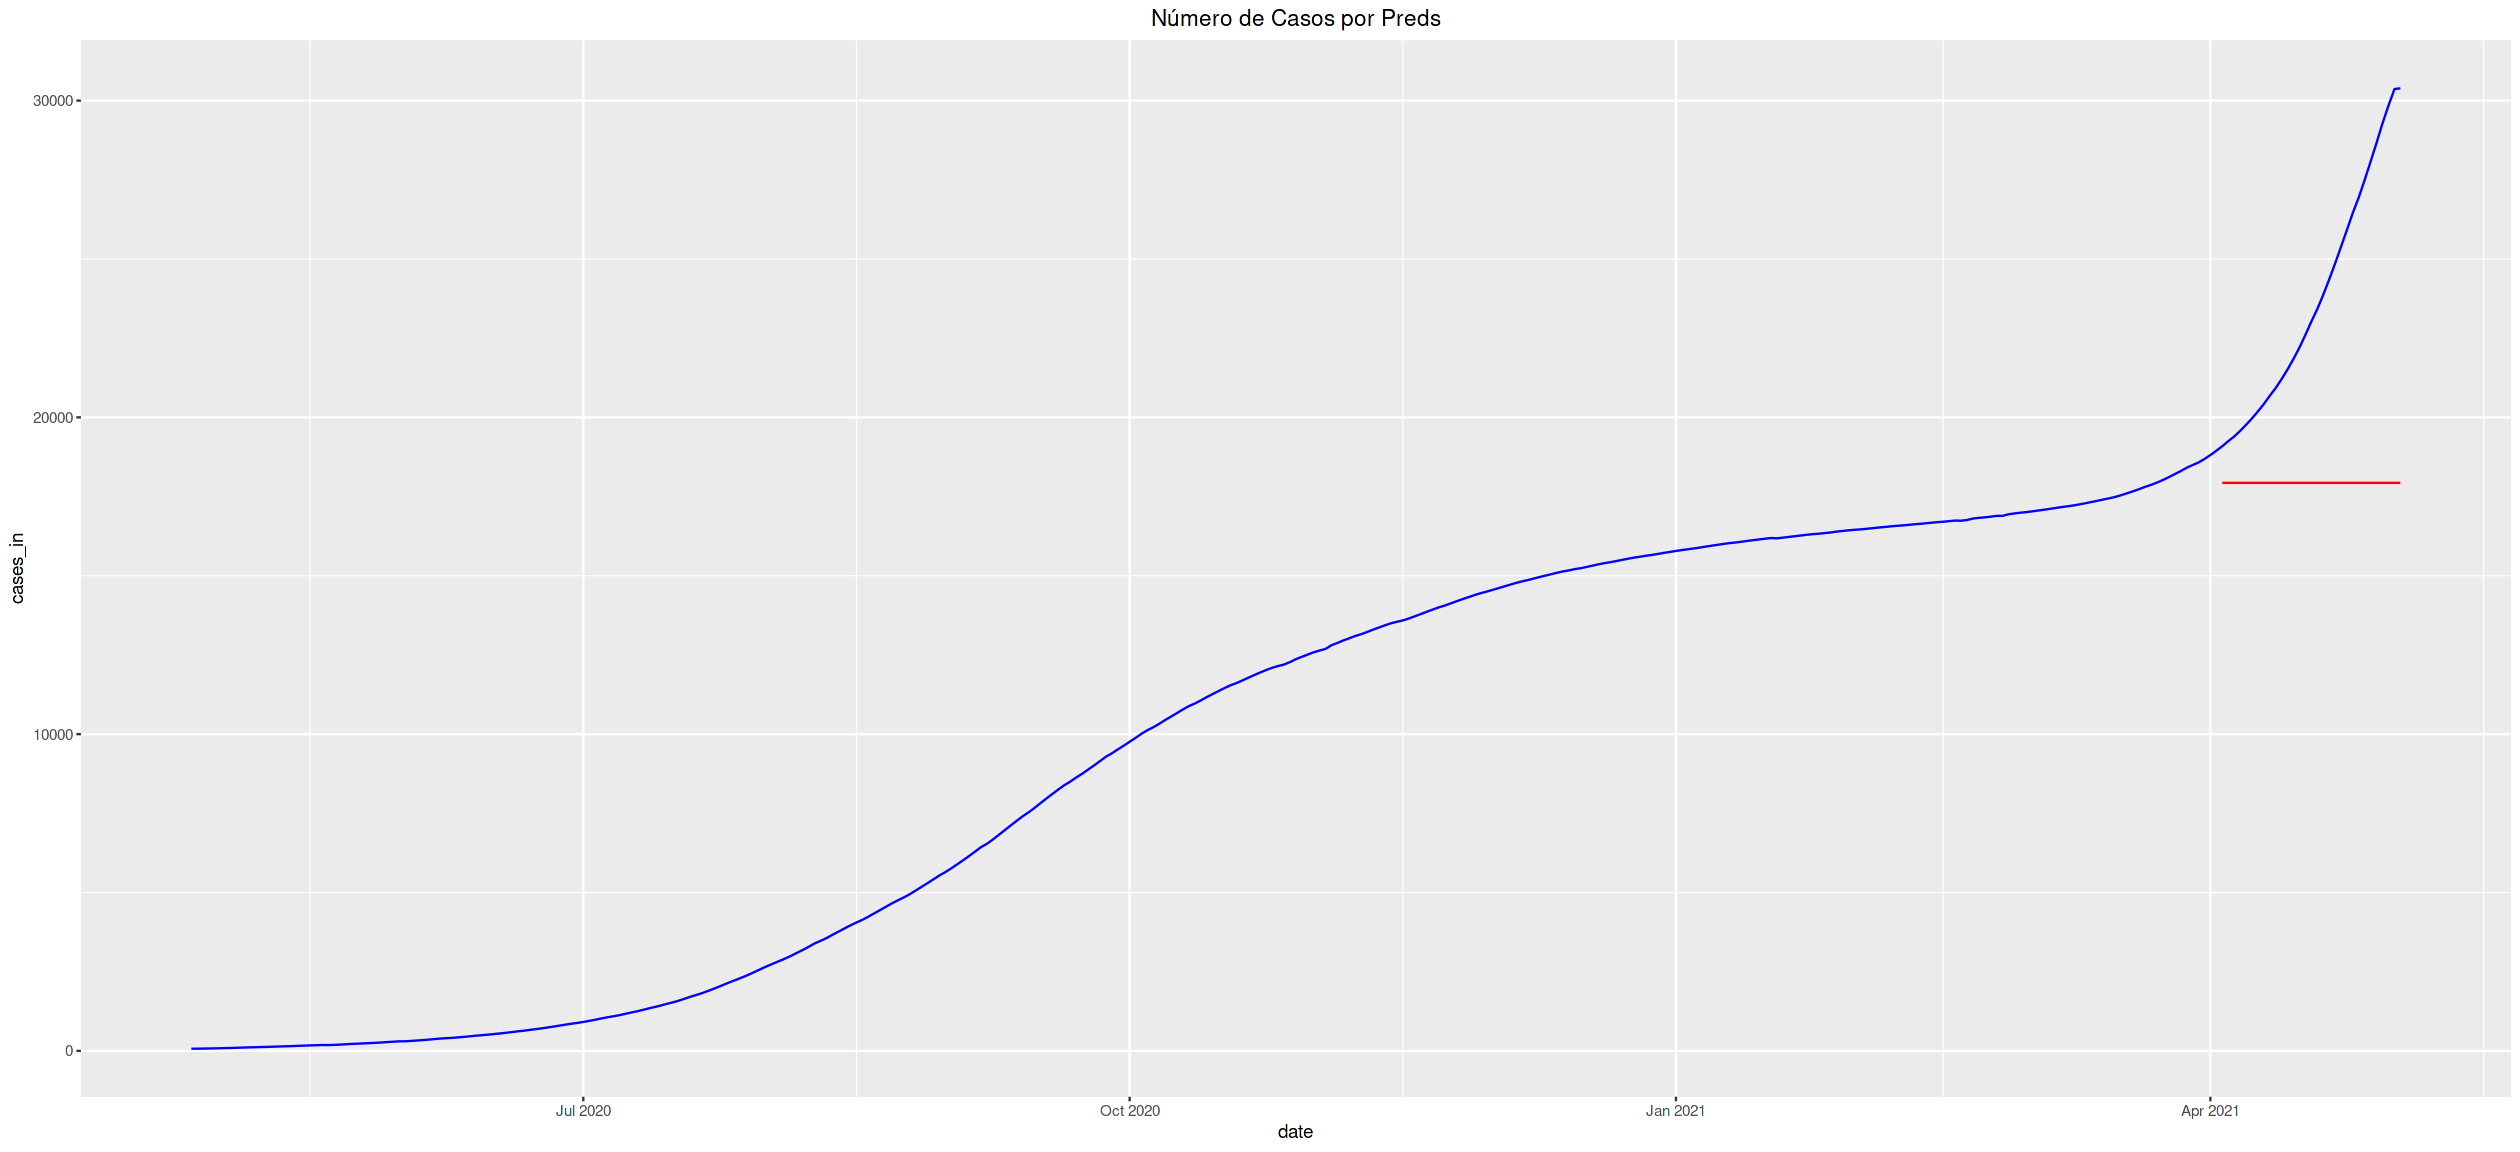

In [45]:
quick_viz_res_line("cases_in")

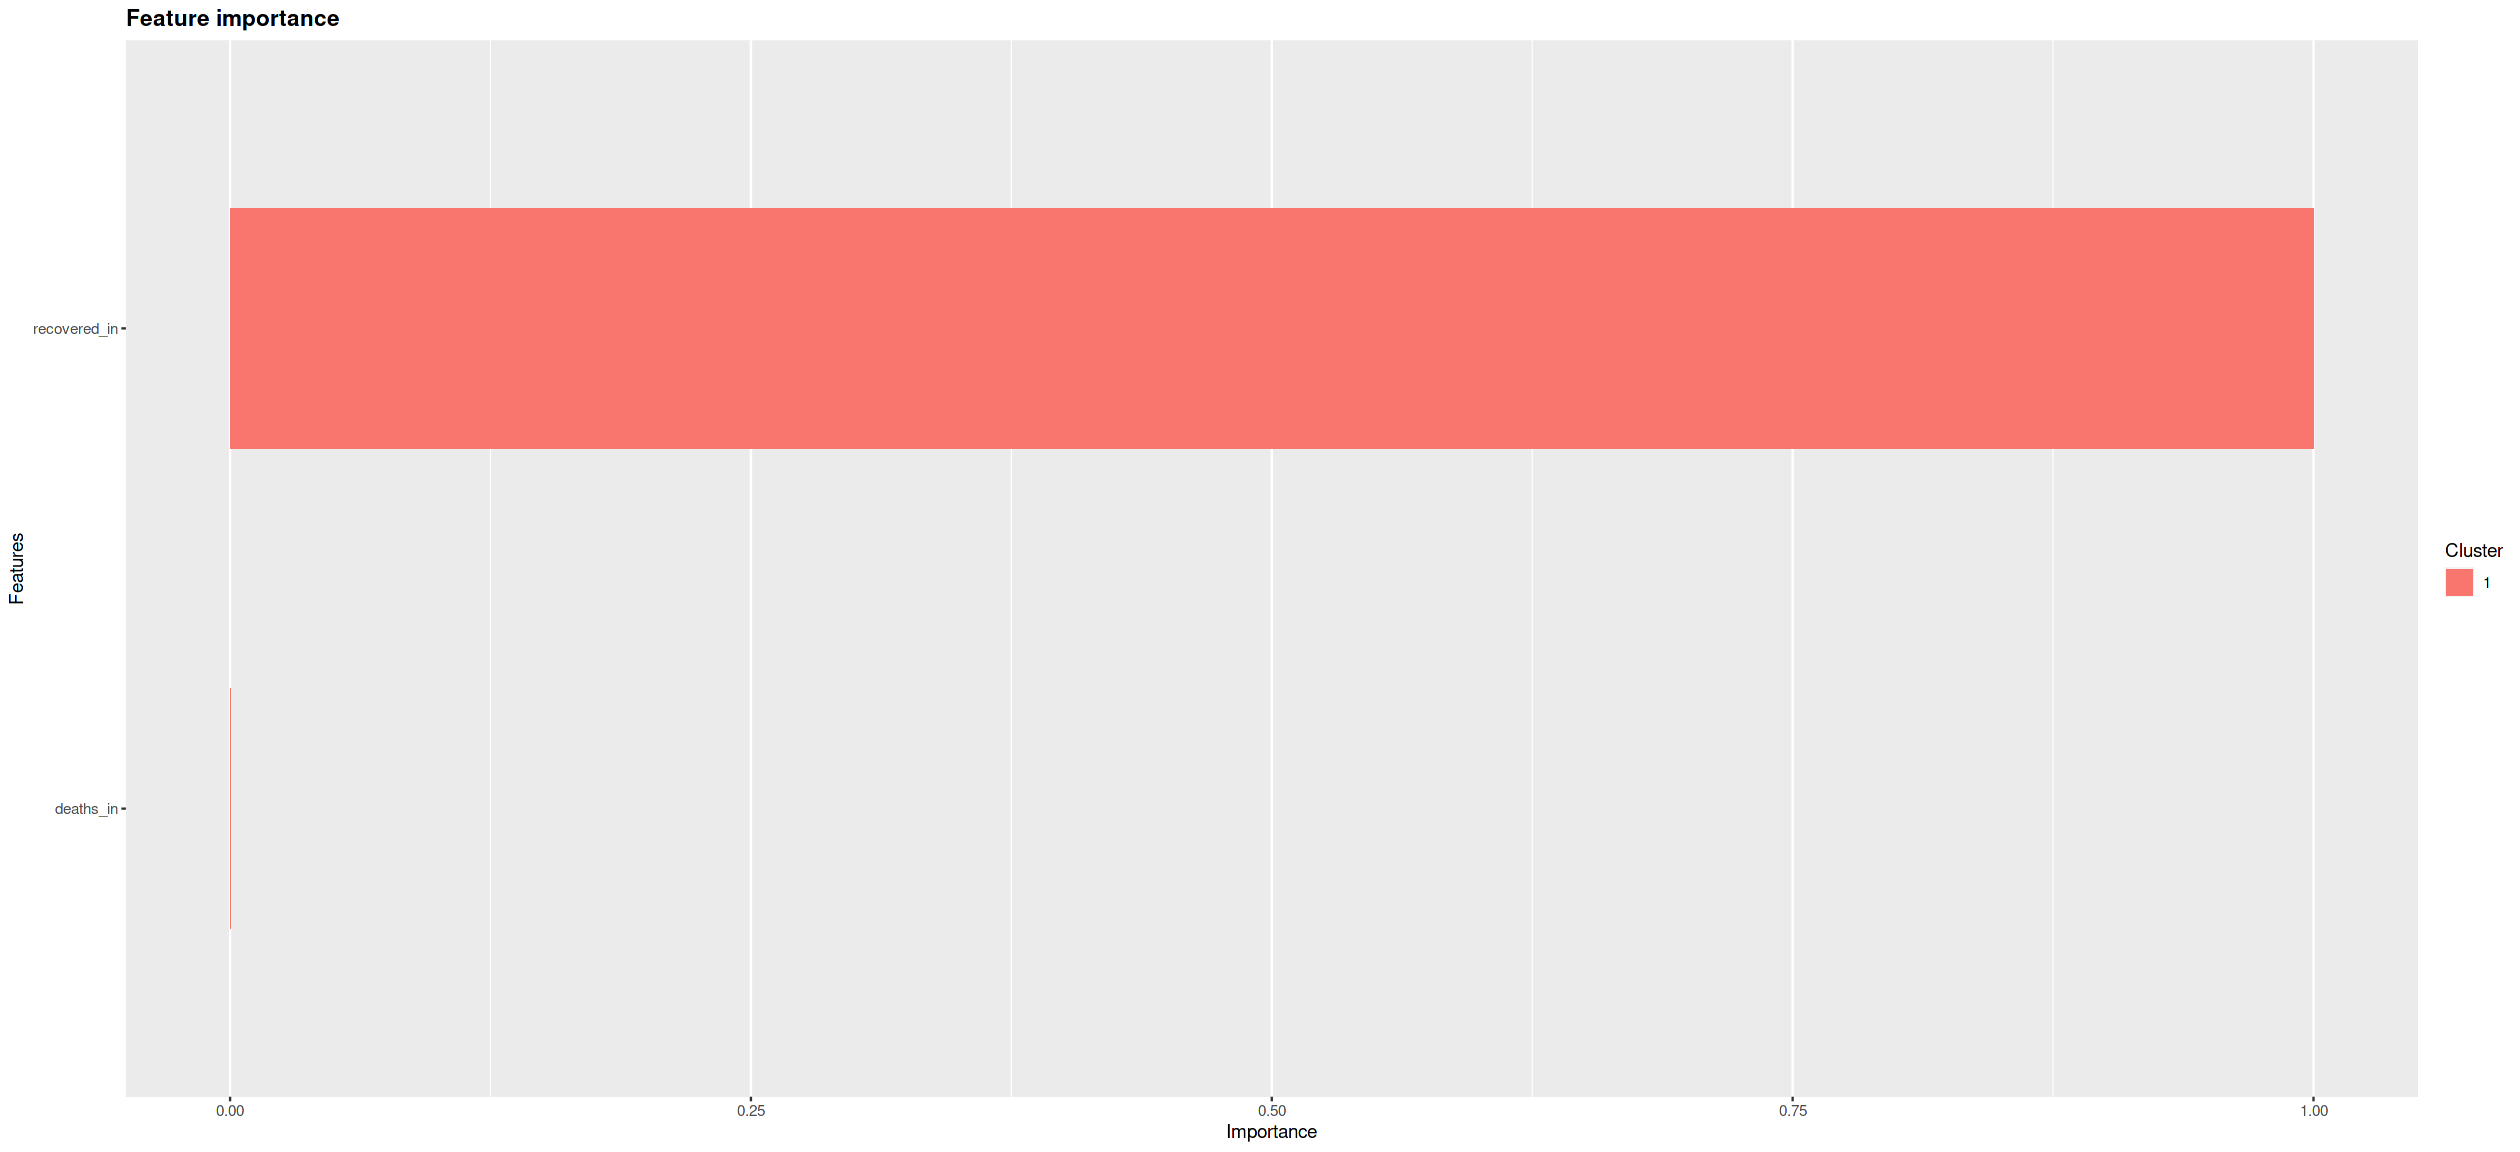

In [46]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_in_grouped %>% select(-date, -cases_in)),
    model = xgb_model_in_grouped$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h3 style= "color:red">No Agrupados</h3>

In [47]:
train_Dmatrix <- train_in %>%
    select(-c(1:4)) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_in %>%
    select(-c(1:4)) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_in$cases_in

In [48]:
# Building the model for india
tic()
xgb_model_in <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

1123.181 sec elapsed


In [49]:
xgb_model_in$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
303,200,20,0.02,0,1,1,1


In [50]:
preds <- caret::predict.train(xgb_model_in, pred_Dmatrix)
test_in$Preds <- preds
df_india <- bind_rows(train_in, test_in)

Warning message:
“Removed 218665 rows containing missing values (position_stack).”


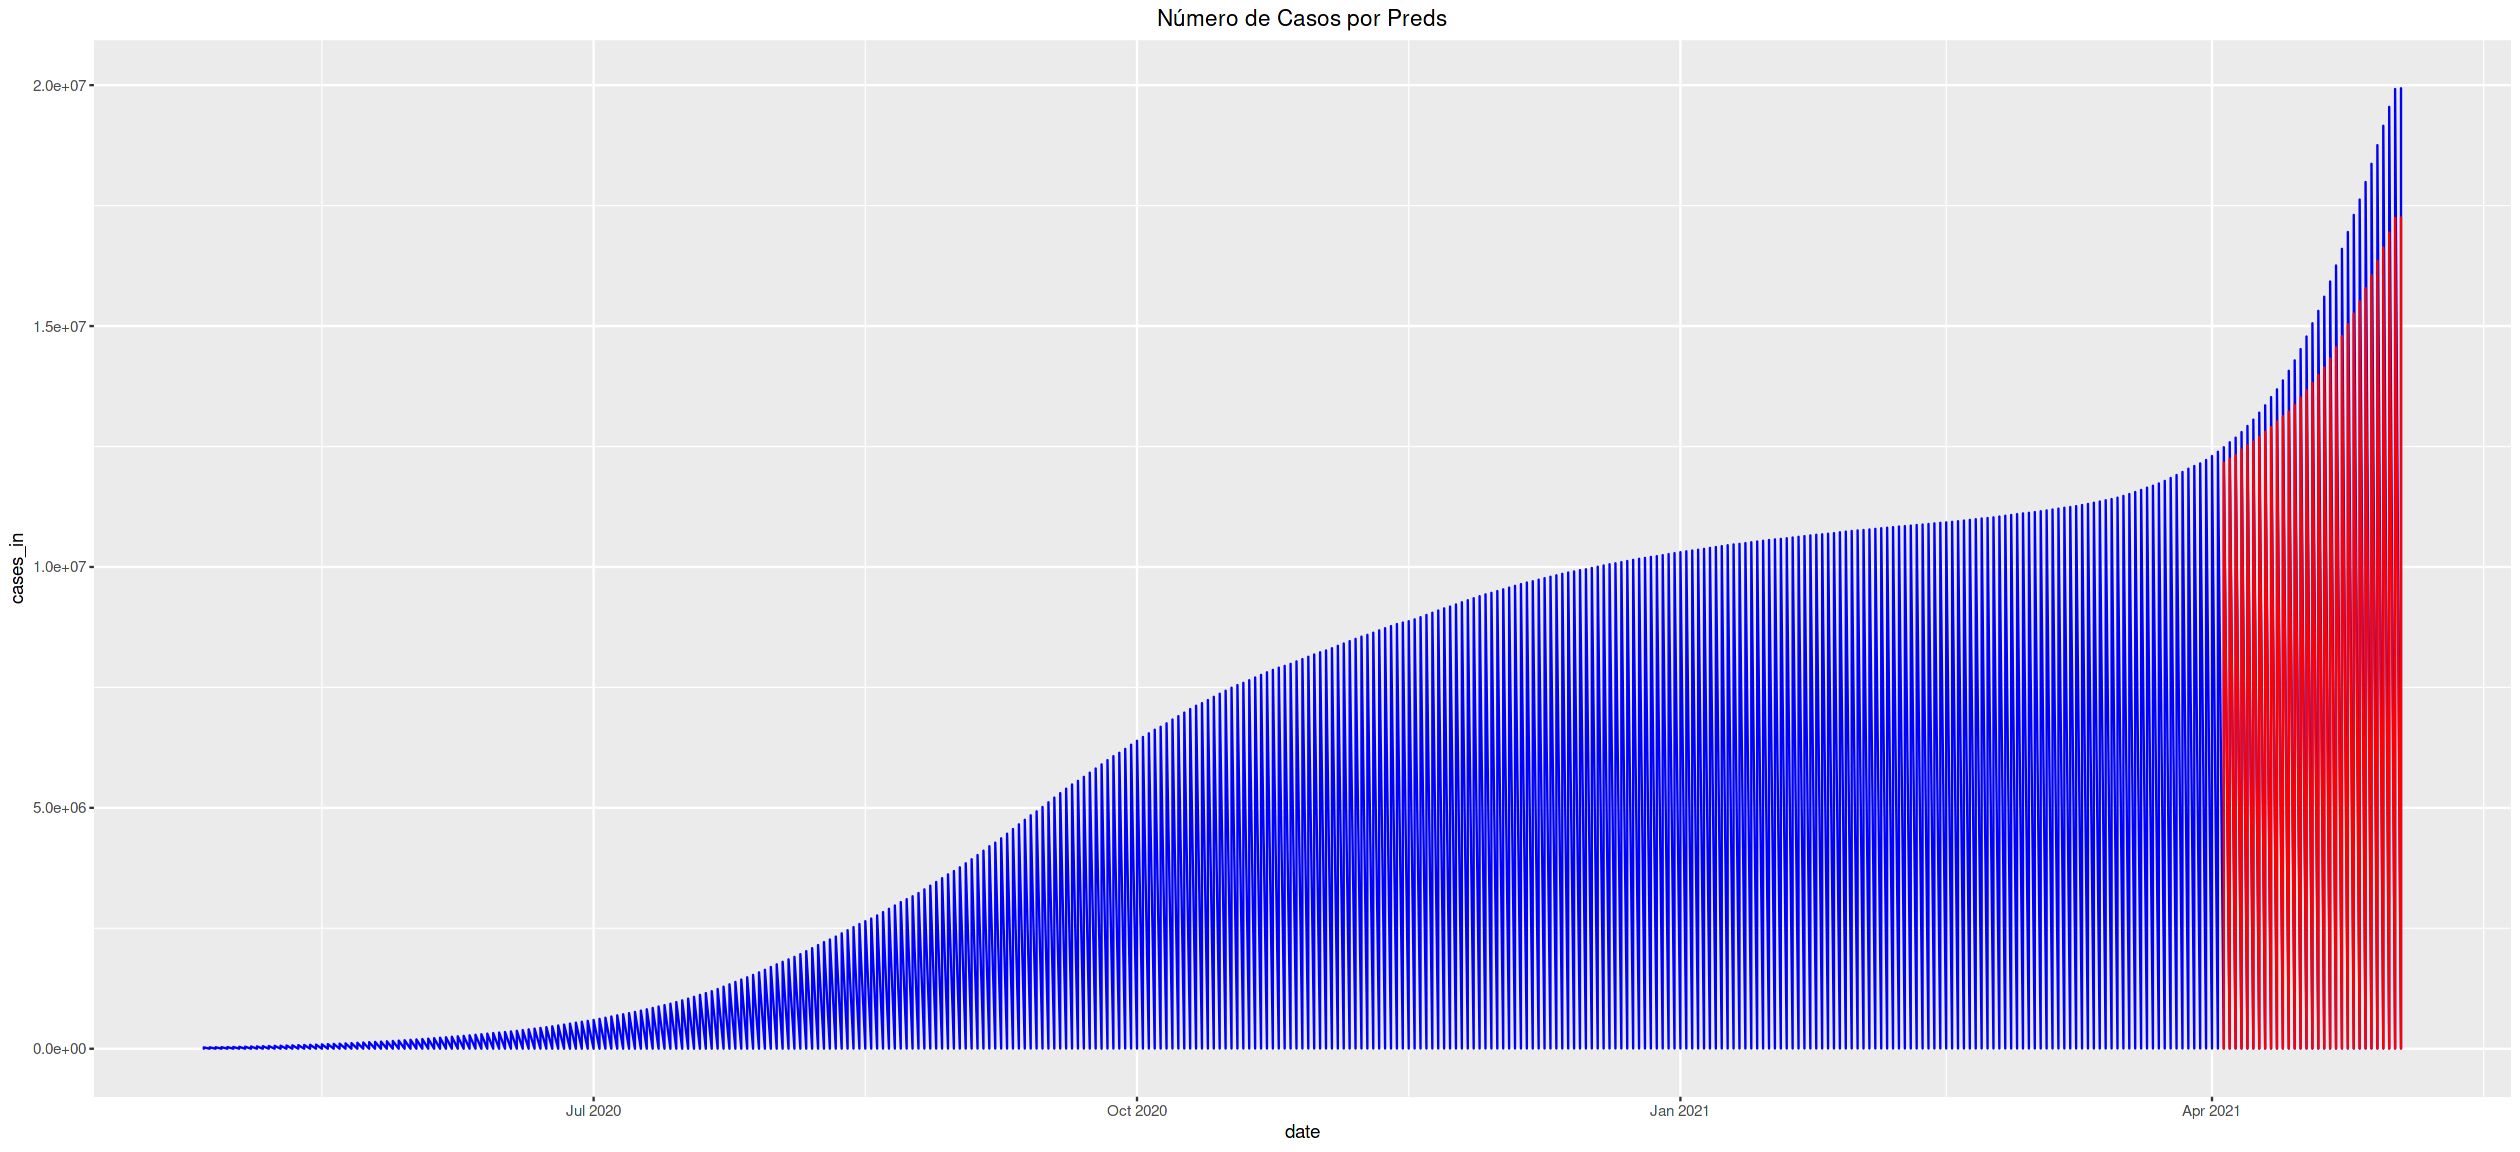

In [51]:
quick_viz_res_area(df_india, "cases_in")

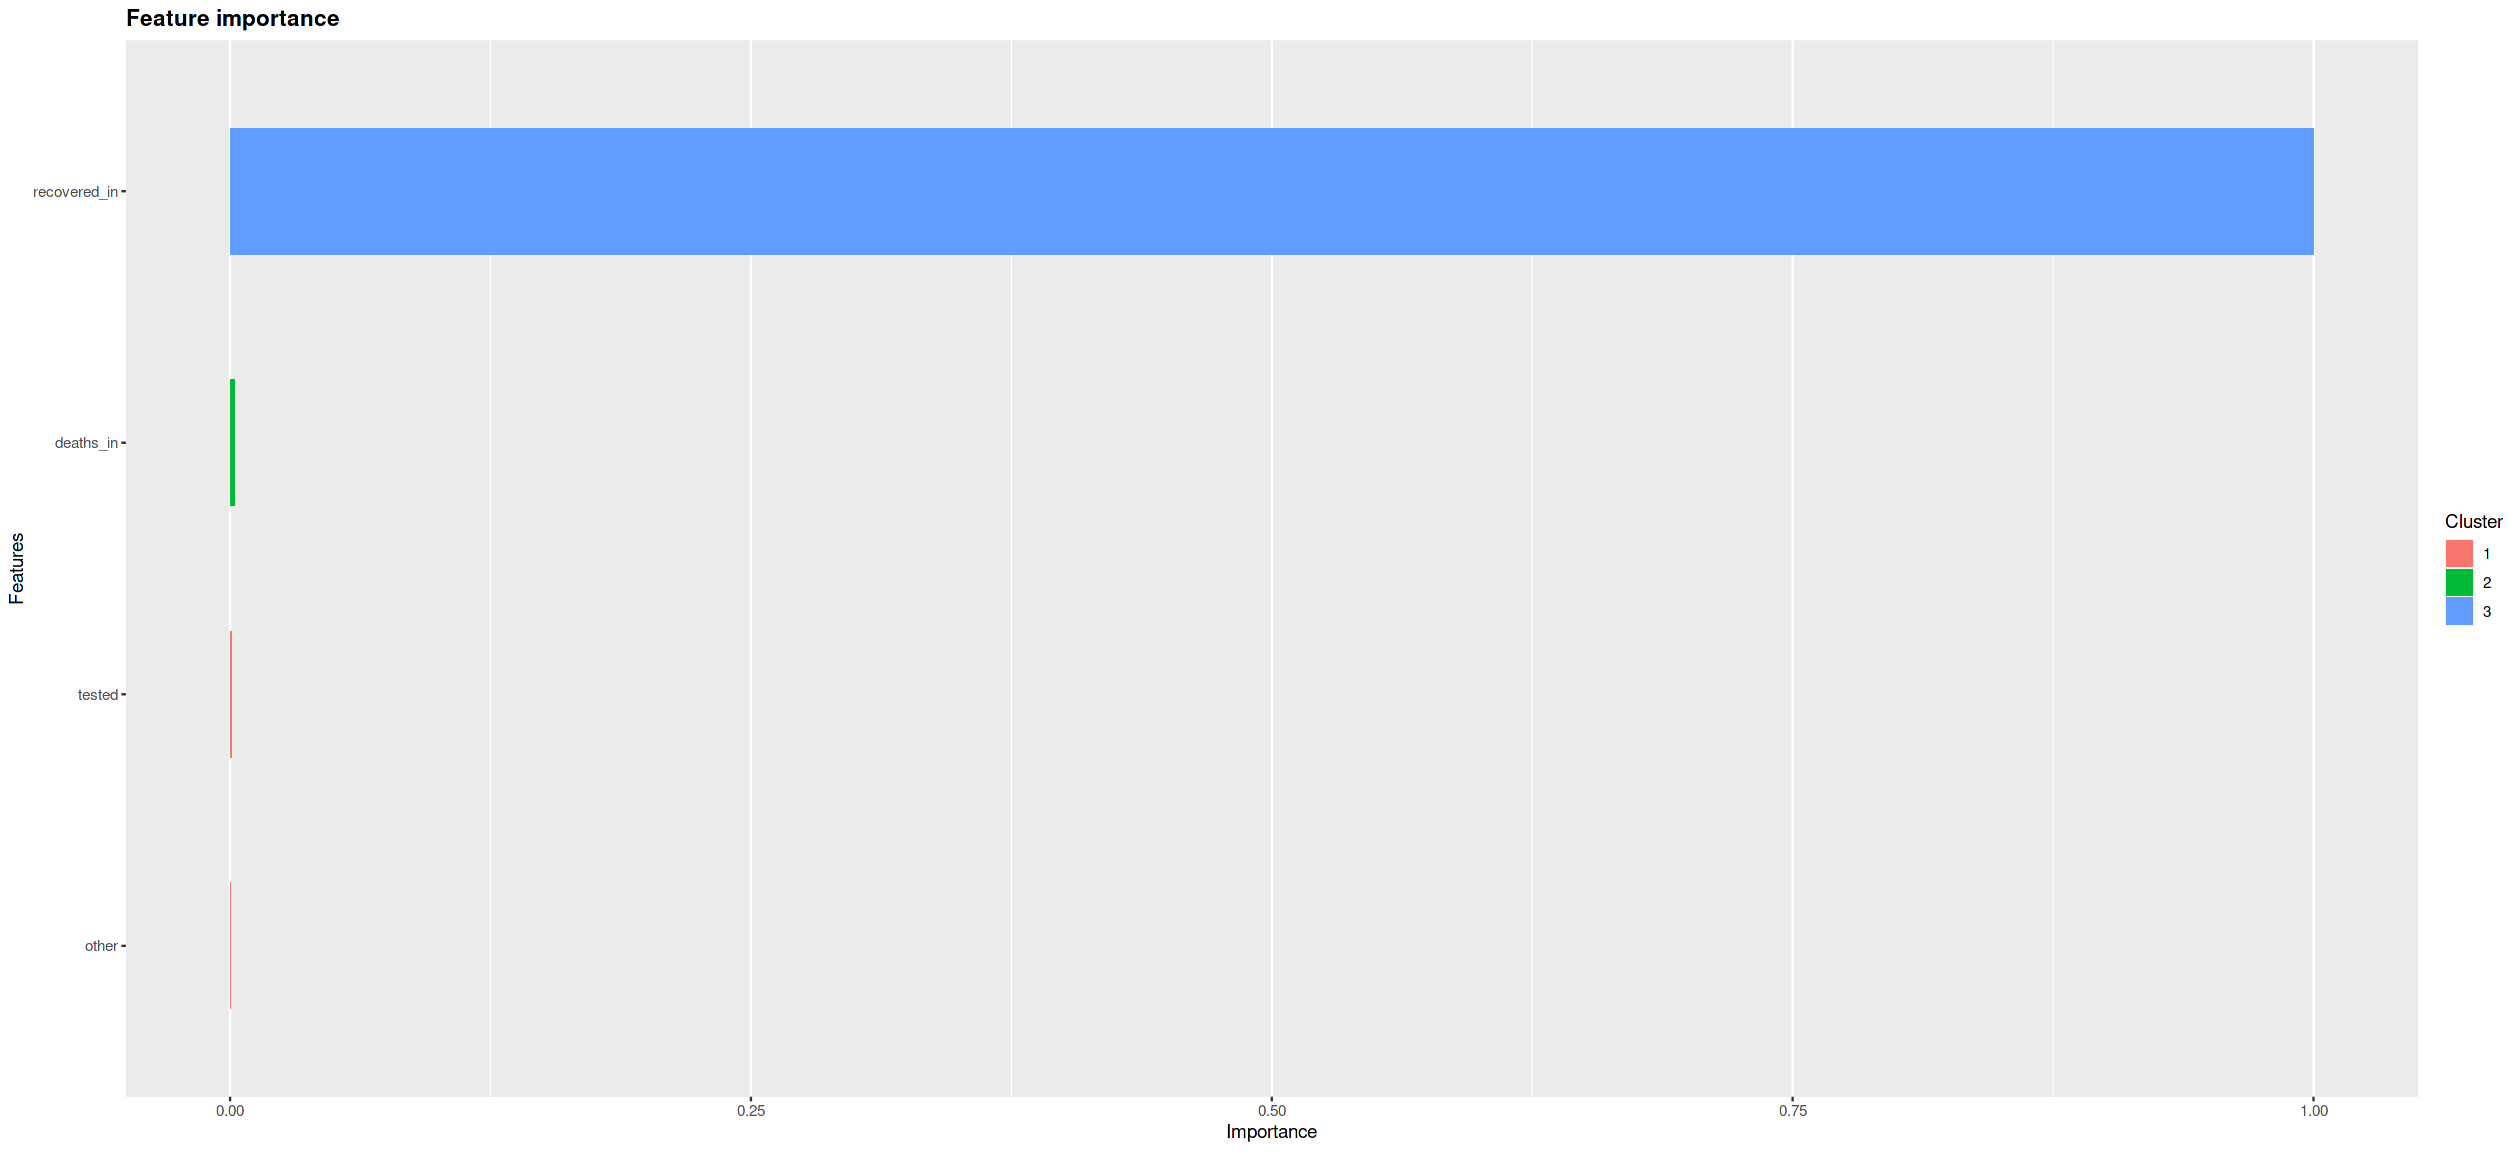

In [52]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_in %>% select(-c(1:4))),
    model = xgb_model_in$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h2 style= "color:blue">Gran Bretaña</h2>


<h3 style= "color:red">Agrupados</h3>

In [53]:
train_gb_grouped <- train_gb %>% group_by(date) %>%
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
    )

test_gb_grouped <- test_gb %>% group_by(date) %>% 
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
    )

In [54]:
train_Dmatrix <- train_gb_grouped %>%
    select(-date, -cases_gb) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_gb_grouped %>%
    select(-date, -cases_gb) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_gb_grouped$cases_gb

In [55]:
tic()
xgb_model_gb_grouped <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

18.447 sec elapsed


In [56]:
xgb_model_gb_grouped$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,101,6,0.02,0,1,1,1


In [57]:
preds <- caret::predict.train(xgb_model_gb_grouped, pred_Dmatrix)
test_gb_grouped$Preds <- preds
df <- bind_rows(train_gb_grouped, test_gb_grouped)

In [58]:
train_gb_grouped

date,cases_gb,deaths_gb
<date>,<dbl>,<dbl>
2020-03-03,0.0000000,1.0000000
2020-03-04,1.0000000,0.0000000
2020-03-05,0.2000000,0.4000000
2020-03-06,0.4000000,0.0000000
2020-03-07,0.0000000,0.0000000
2020-03-08,0.1250000,0.3750000
2020-03-09,0.3846154,0.3846154
2020-03-10,1.7333333,0.2000000
2020-03-11,3.2173913,0.3478261


Warning message:
“Removed 394 row(s) containing missing values (geom_path).”


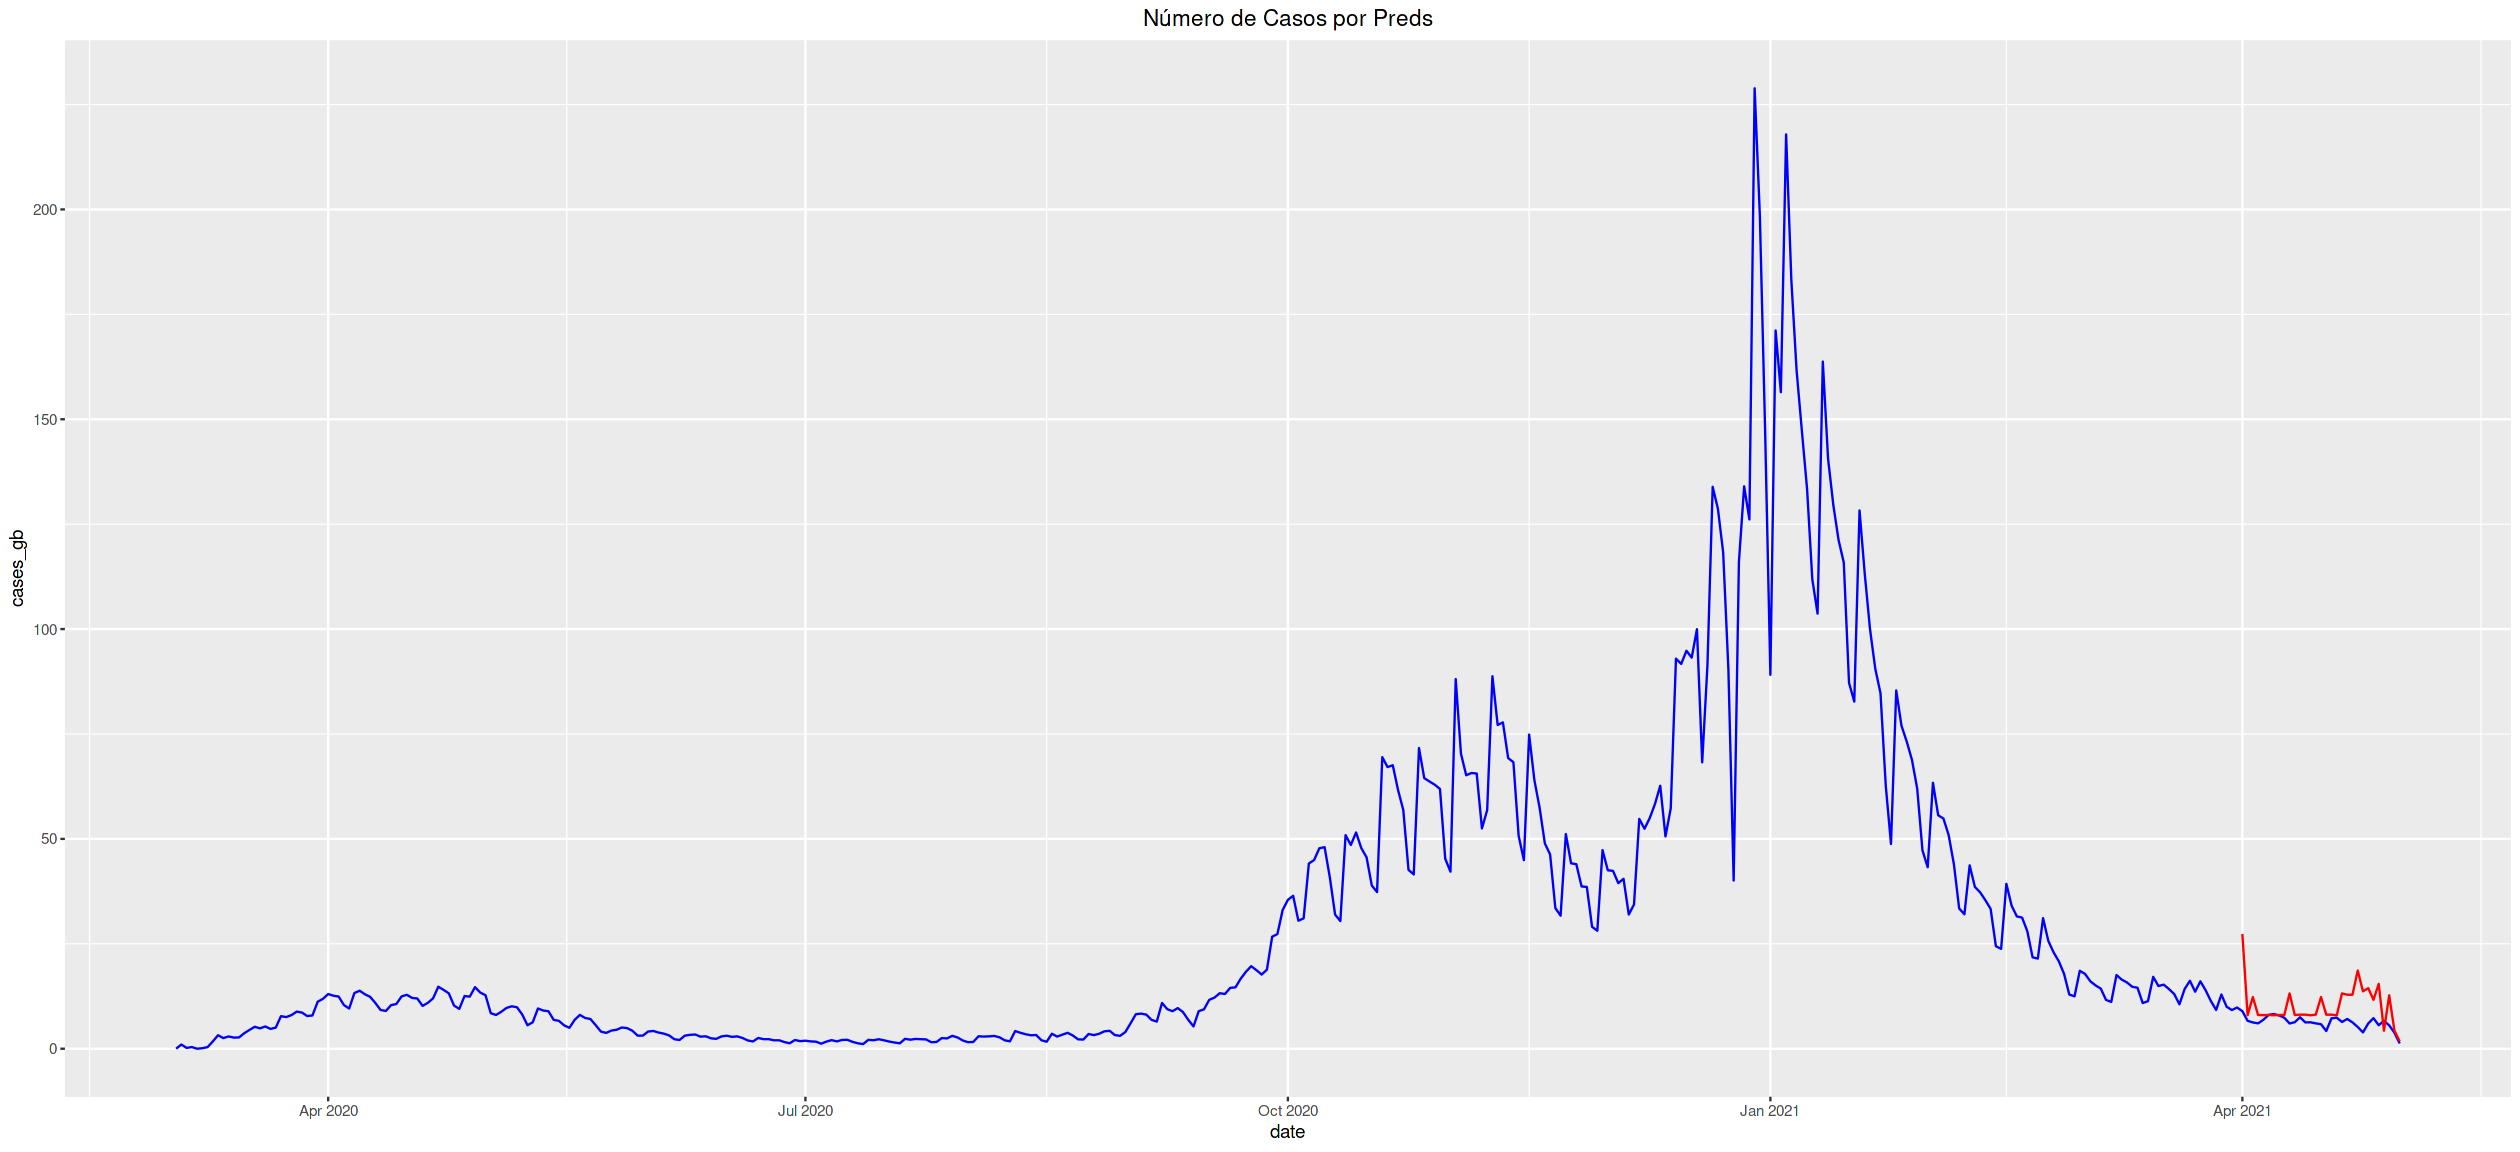

In [59]:
quick_viz_res_line("cases_gb")

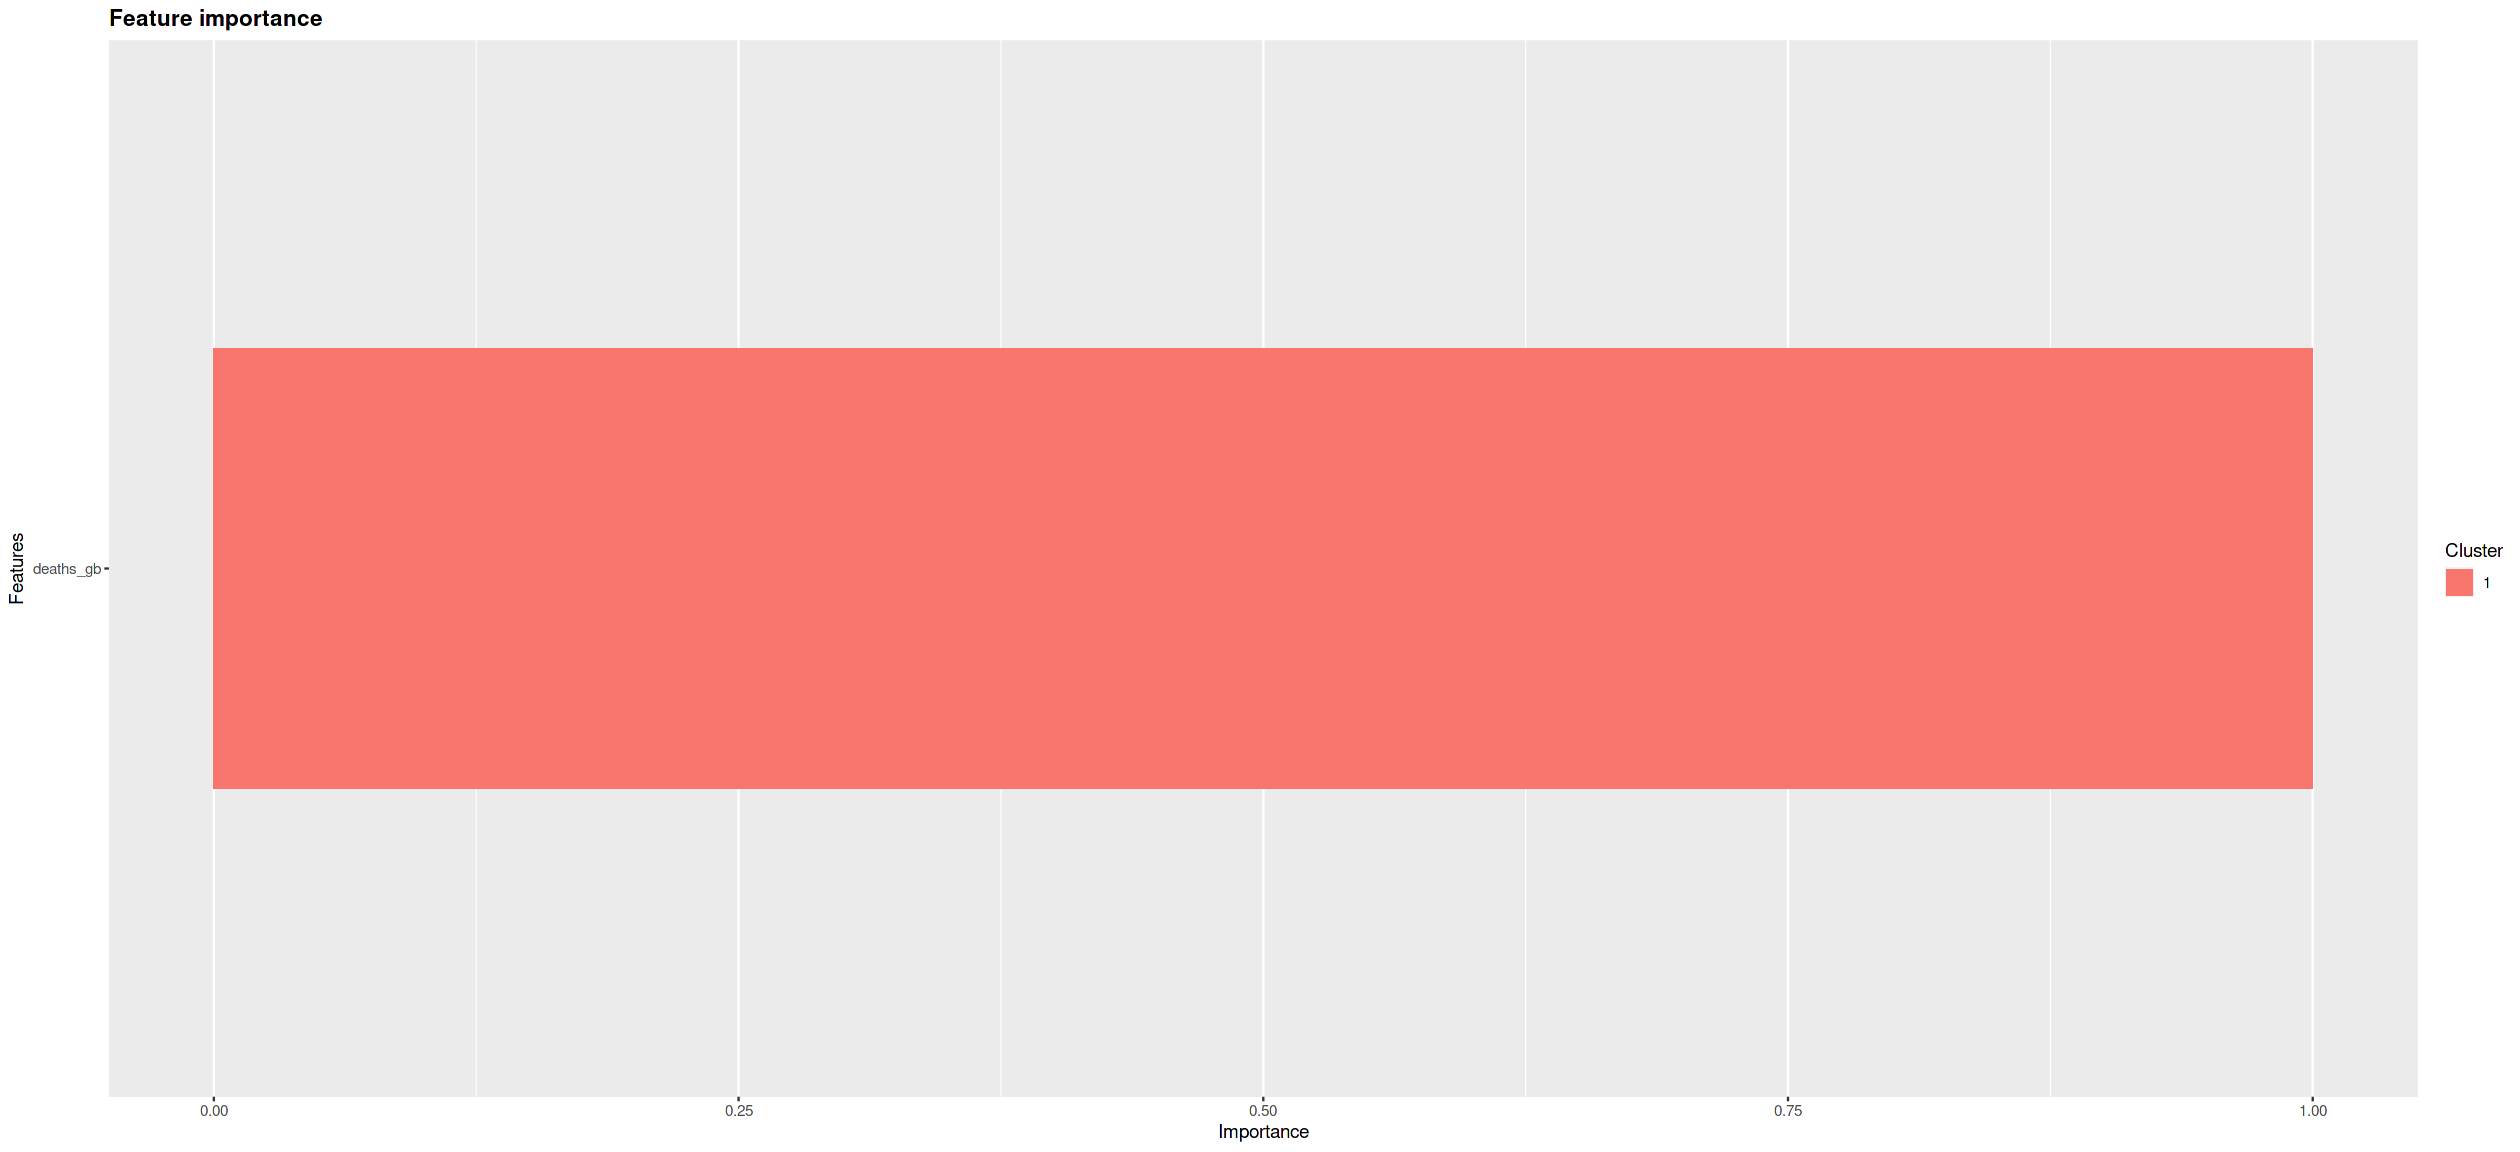

In [60]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_gb_grouped %>% select(-date, -cases_gb)),
    model = xgb_model_gb_grouped$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h3 style= "color:red">No Agrupados</h3>

In [61]:
train_Dmatrix <- train_gb %>%
    select(-c(1:5)) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_gb %>%
    select(-c(1:5)) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_gb$cases_gb

In [62]:
tic()
xgb_model_gb <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

122.667 sec elapsed


In [63]:
xgb_model_gb$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
66,165,6,0.02,0,1,1,1


In [64]:
preds <- caret::predict.train(xgb_model_gb, pred_Dmatrix)
test_gb$Preds <- preds
df_gb <- bind_rows(train_gb, test_gb)

Warning message:
“Removed 118639 rows containing missing values (position_stack).”


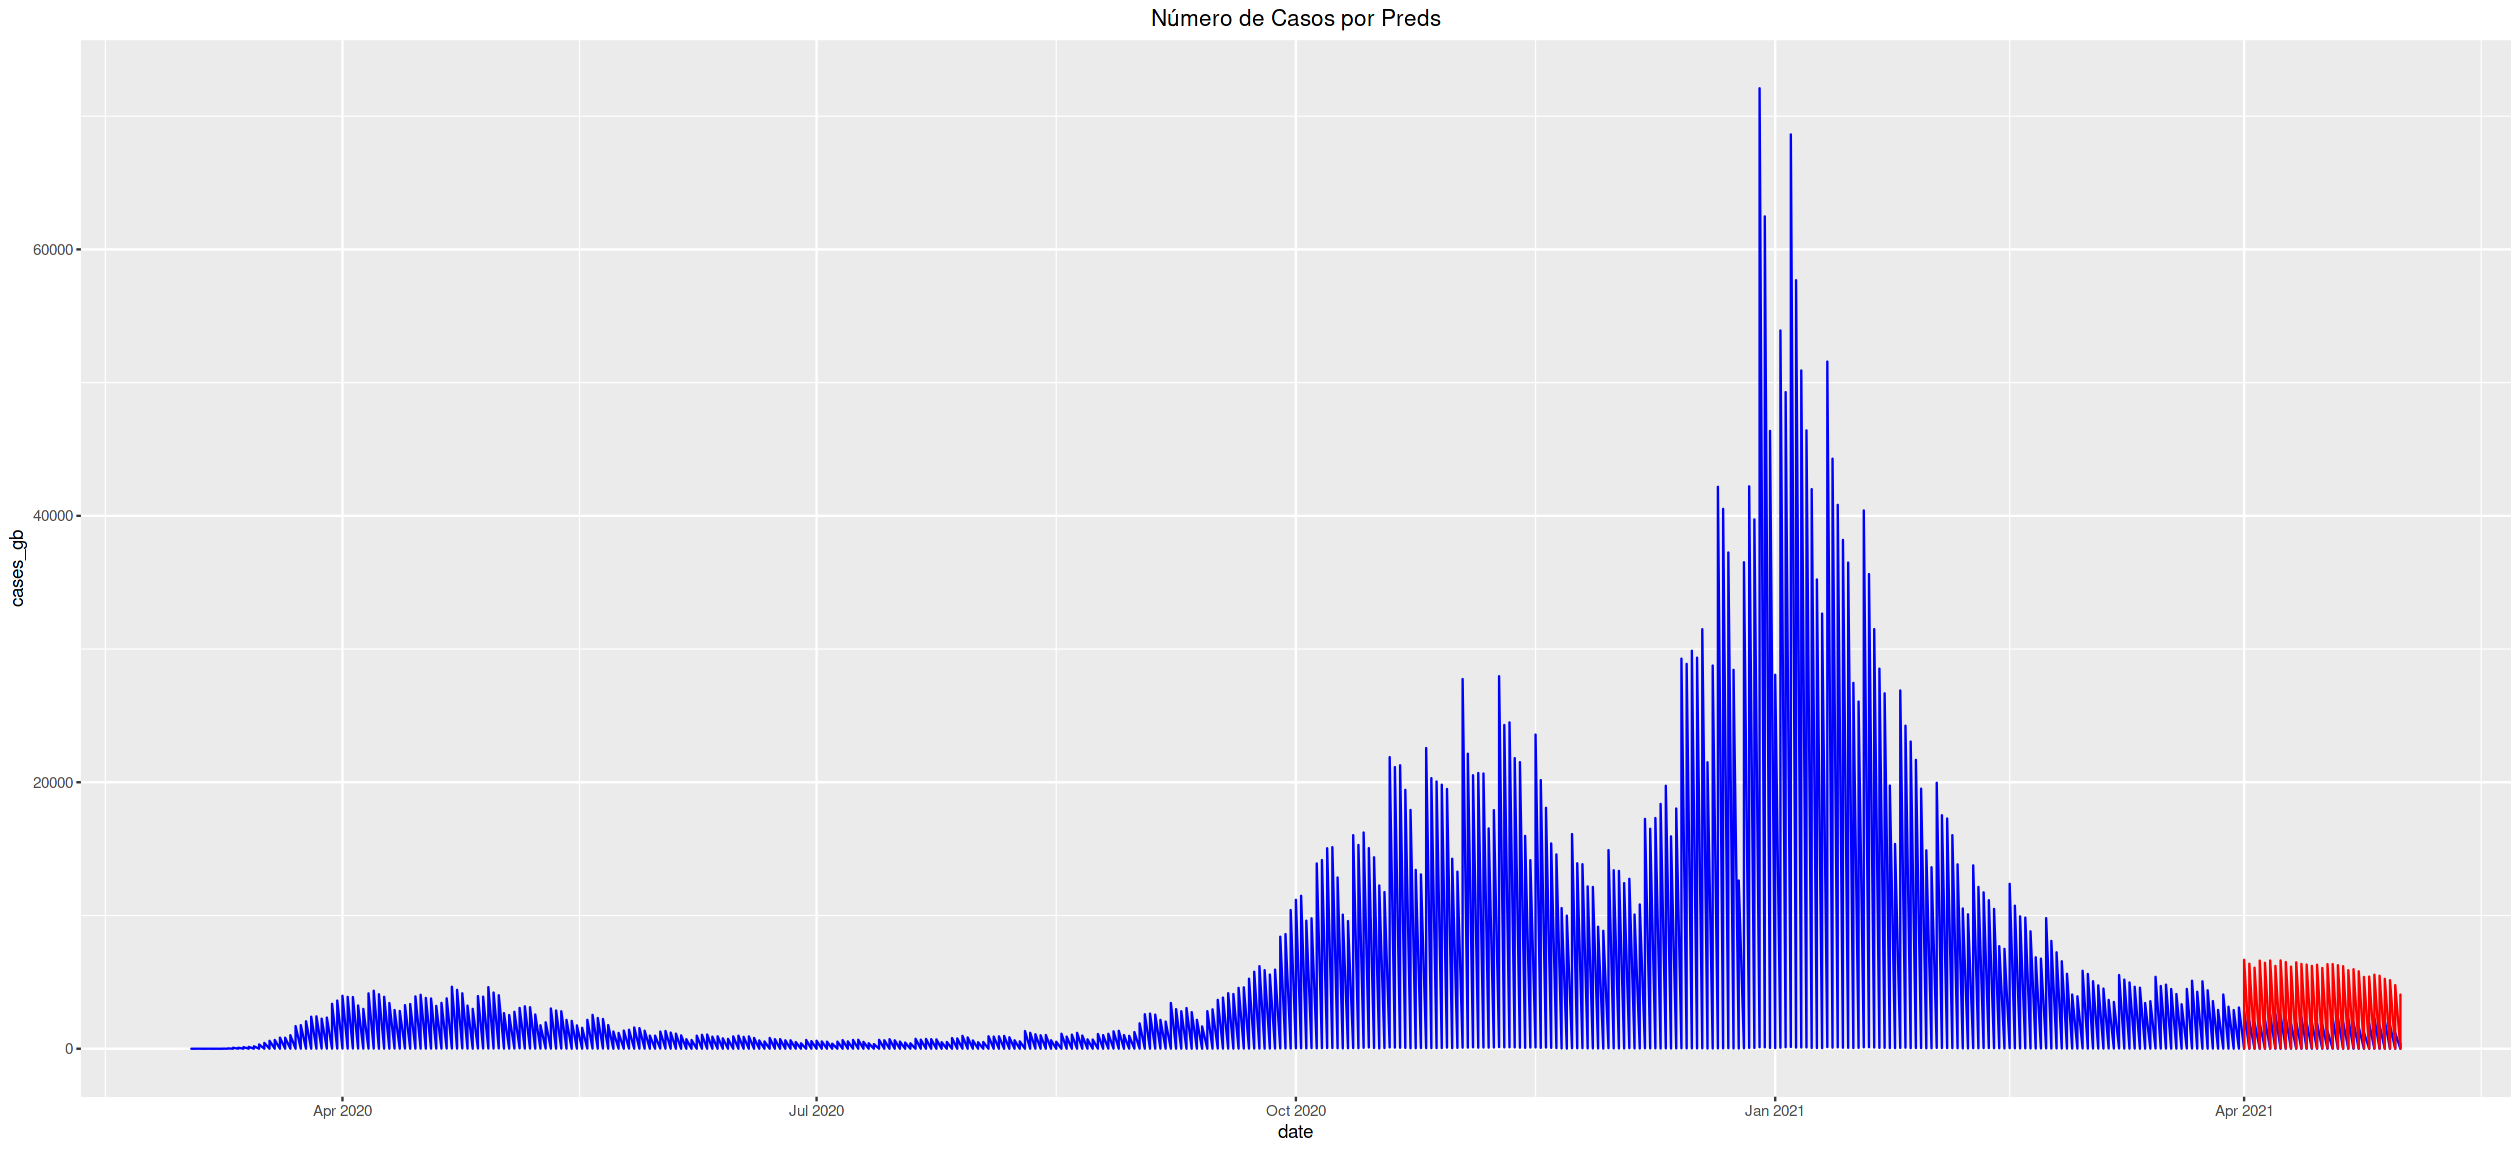

In [65]:
quick_viz_res_area(df_gb, "cases_gb")

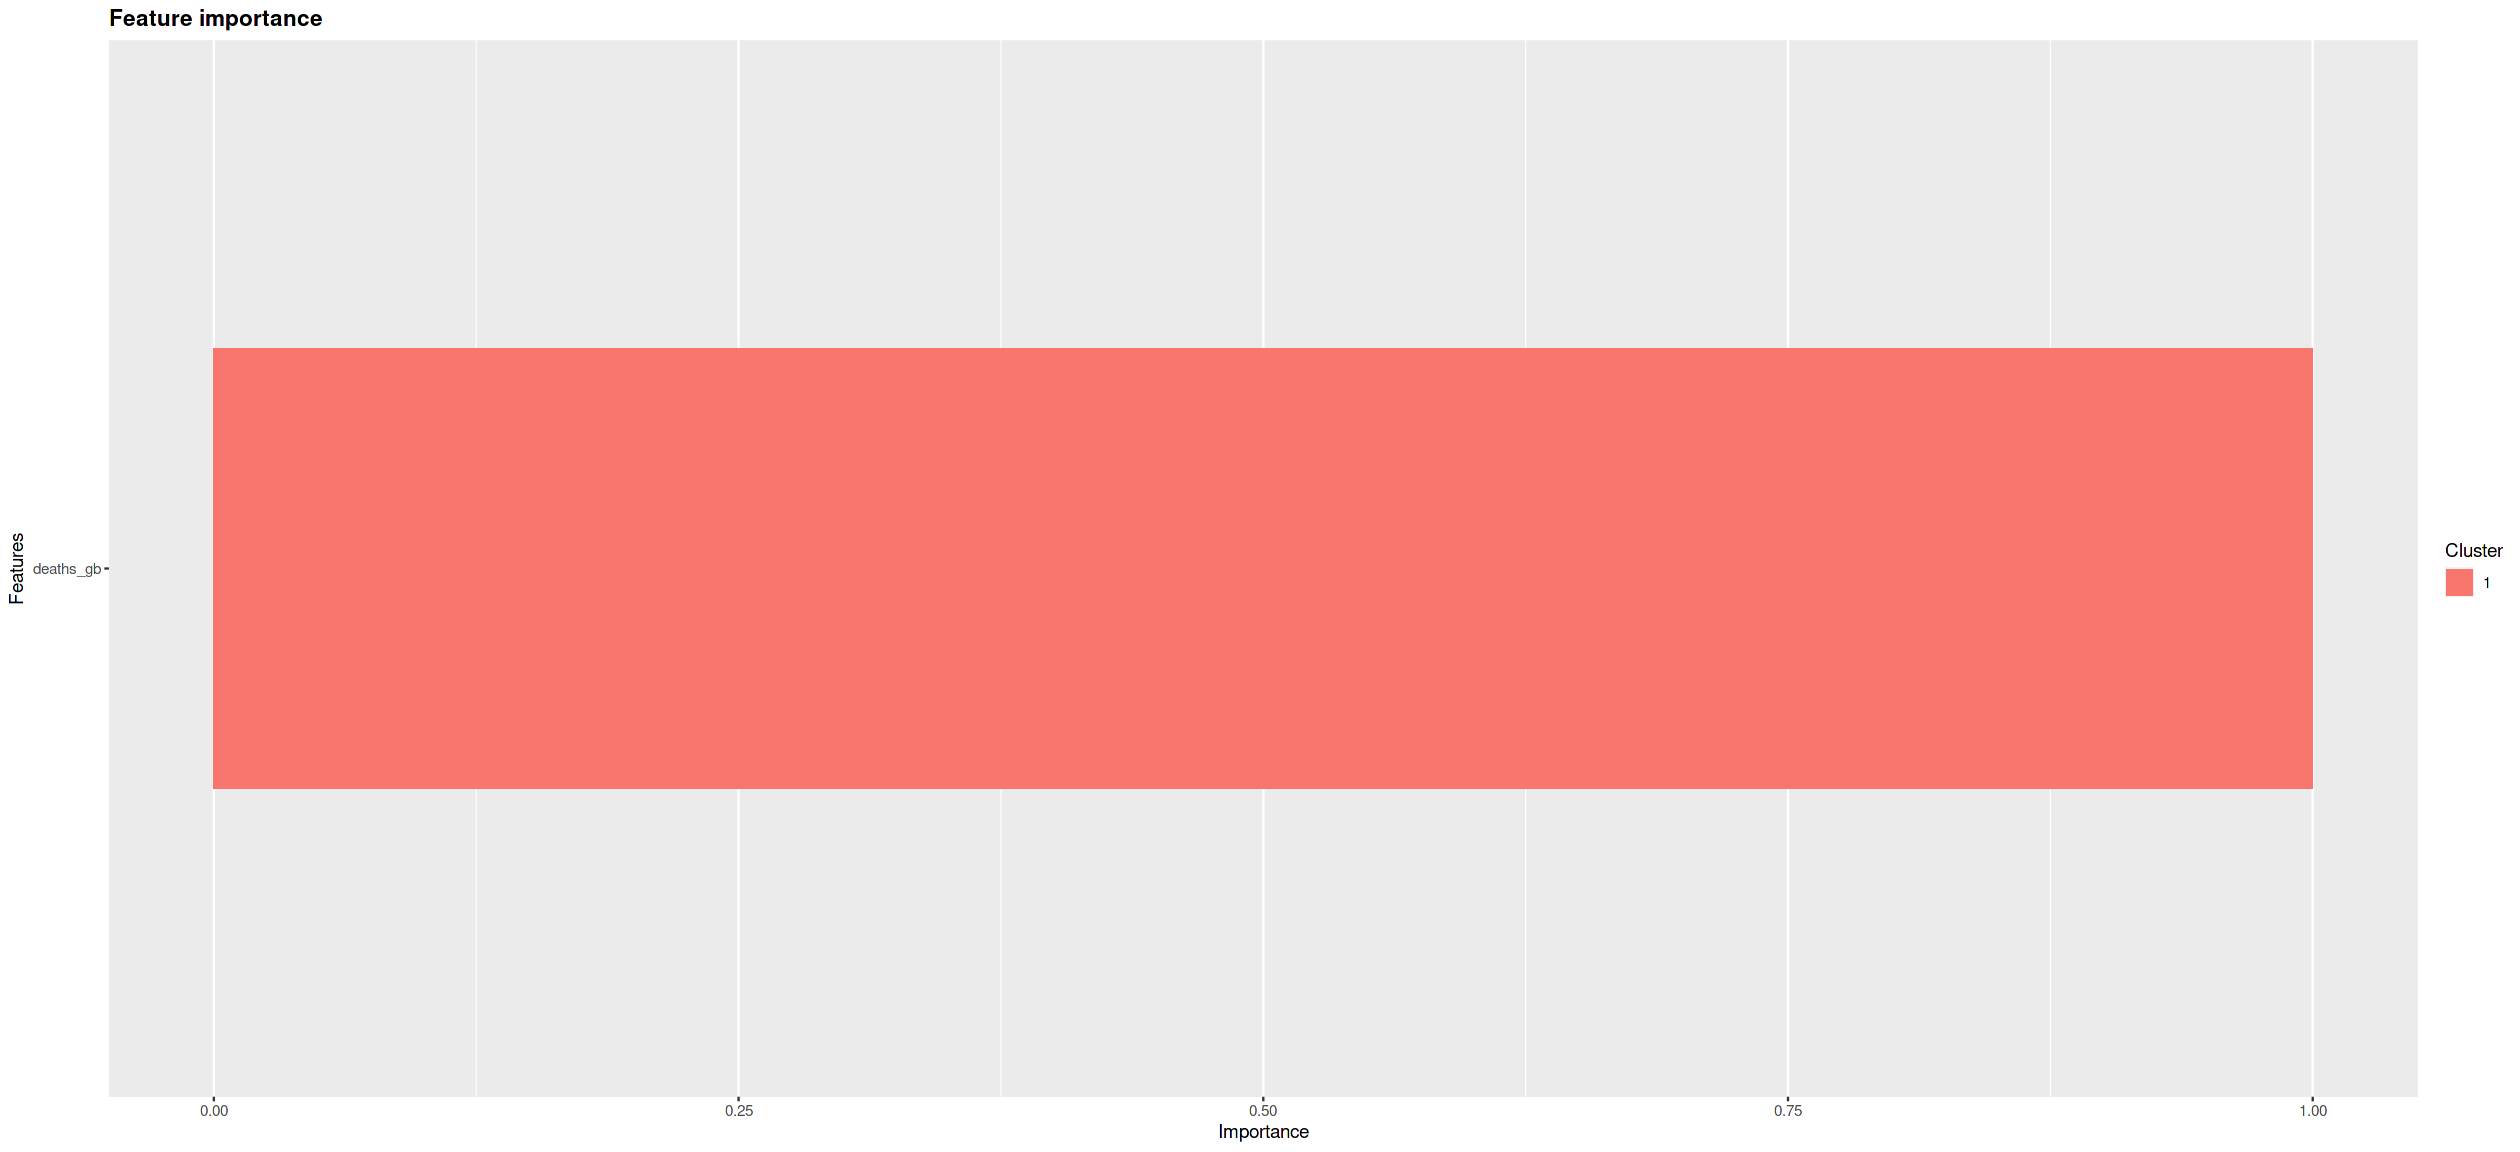

In [66]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_gb %>% select(-c(1:5))),
    model = xgb_model_gb$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h2 style= "color:blue">España</h2>


<h3 style= "color:red">Agrupados</h3>

In [67]:
train_sp_grouped <- train_sp %>% group_by(date) %>%
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
)    
        
test_sp_grouped <- test_sp %>% group_by(date) %>% 
    summarise_if(
        is.numeric,
        mean,
        na.rm = TRUE
)

In [68]:
train_Dmatrix <- train_sp_grouped %>%
    select(-date, -cases_sp) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_sp_grouped %>%
    select(-date, -cases_sp) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_sp_grouped$cases_sp

In [69]:
tic()
xgb_model_sp_grouped <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

12.735 sec elapsed


In [70]:
xgb_model_sp_grouped$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
101,200,6,0.02,0,1,1,1


In [71]:
preds <- caret::predict.train(xgb_model_sp_grouped, pred_Dmatrix)
test_sp_grouped$Preds <- preds
df <- bind_rows(train_sp_grouped, test_sp_grouped)

Warning message:
“Removed 453 row(s) containing missing values (geom_path).”


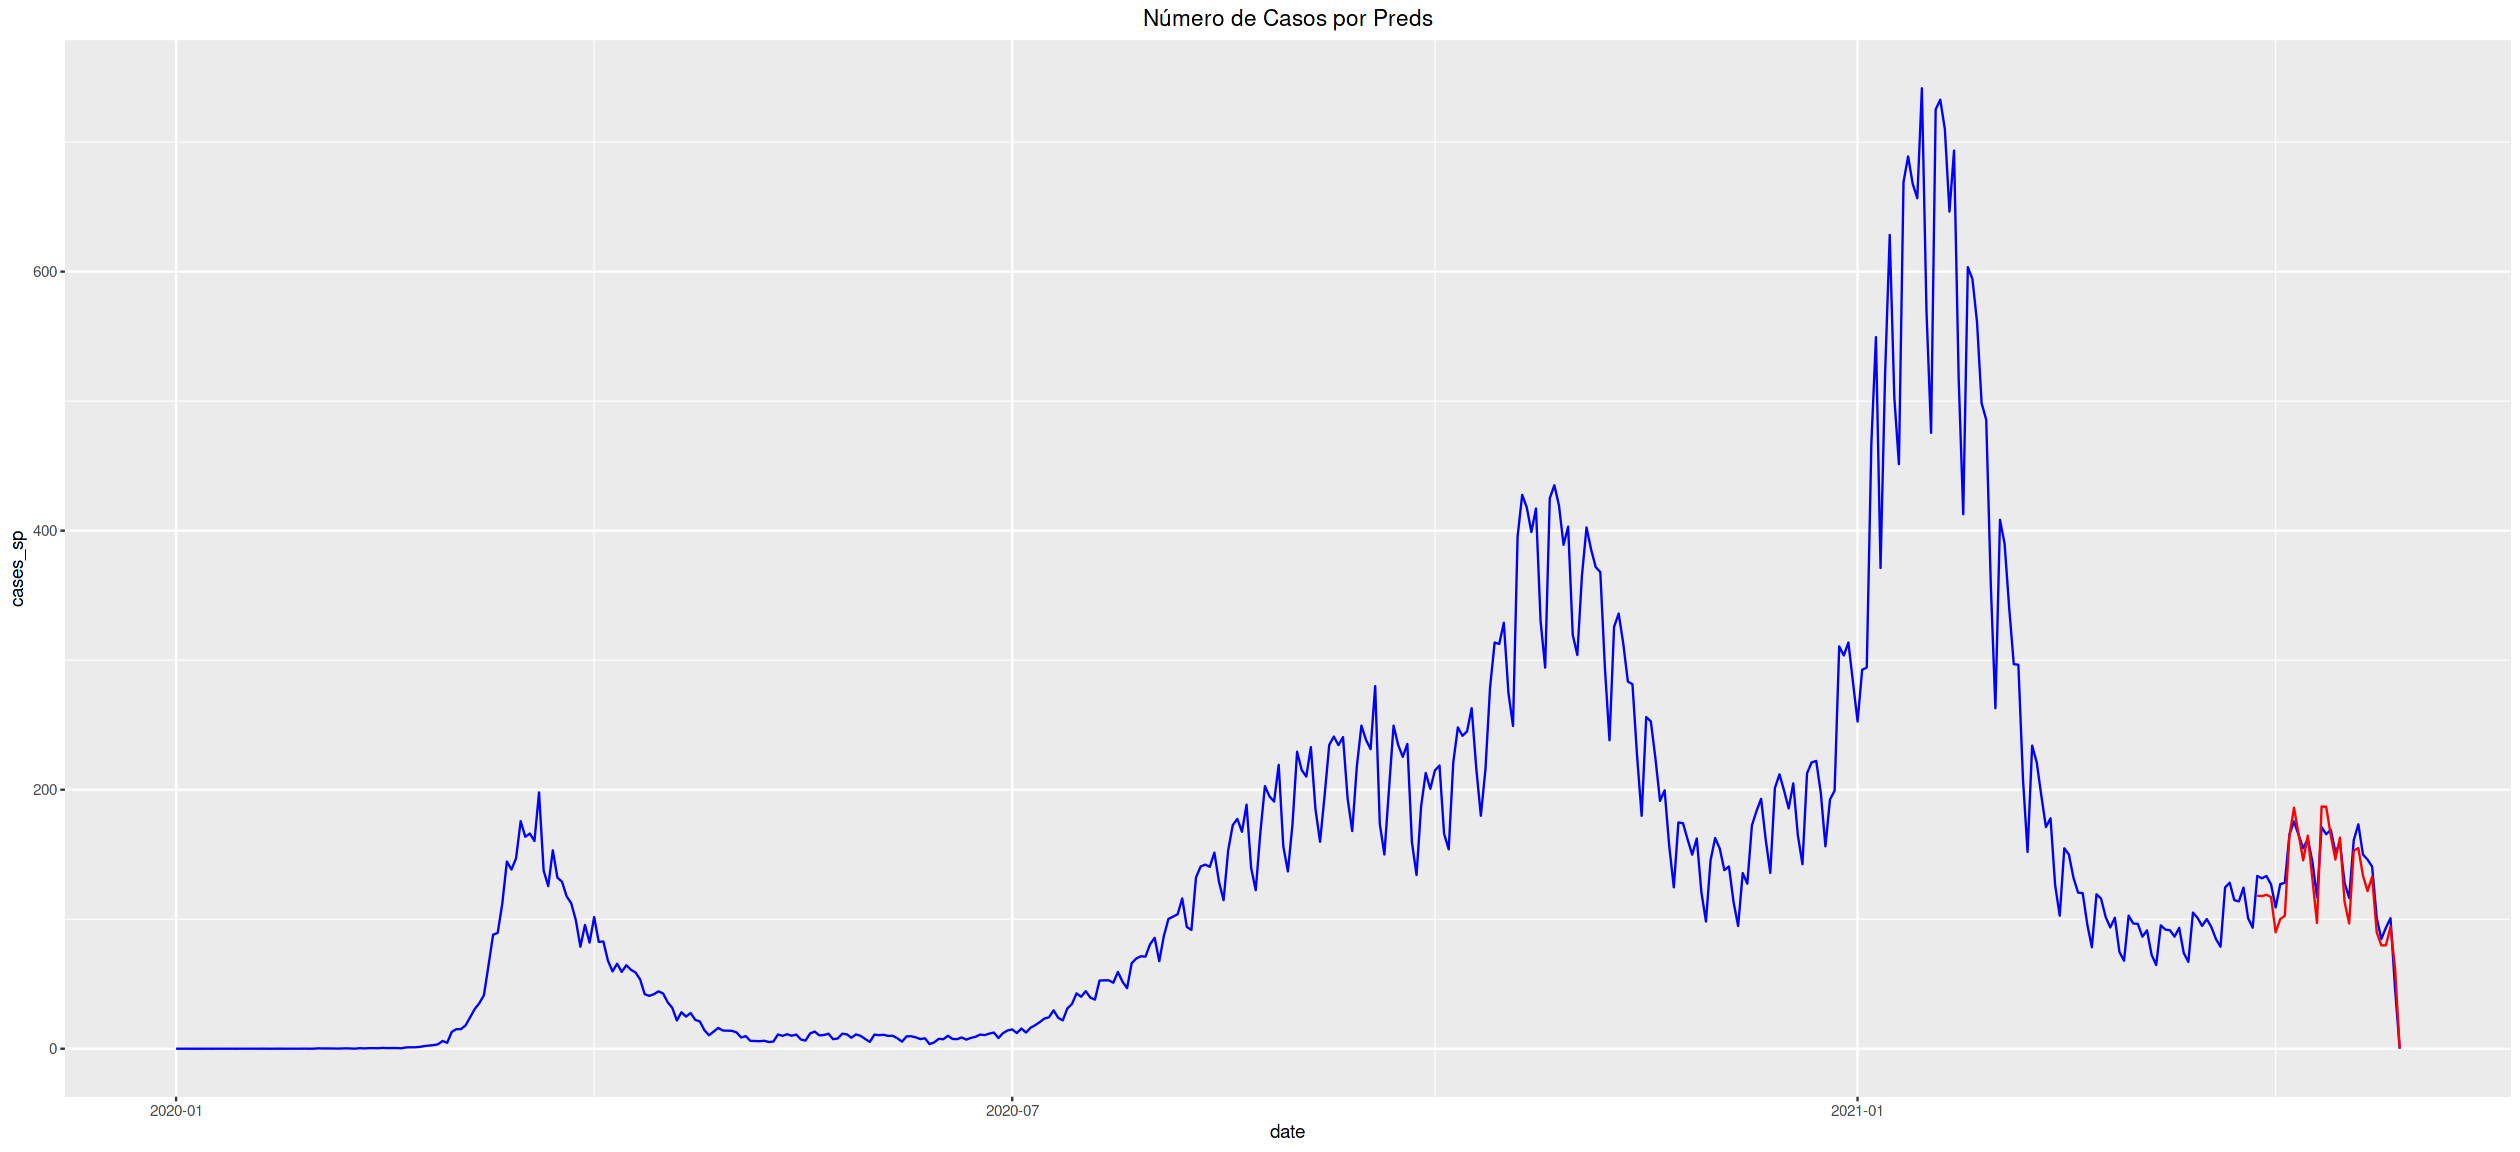

In [72]:
quick_viz_res_line("cases_sp")

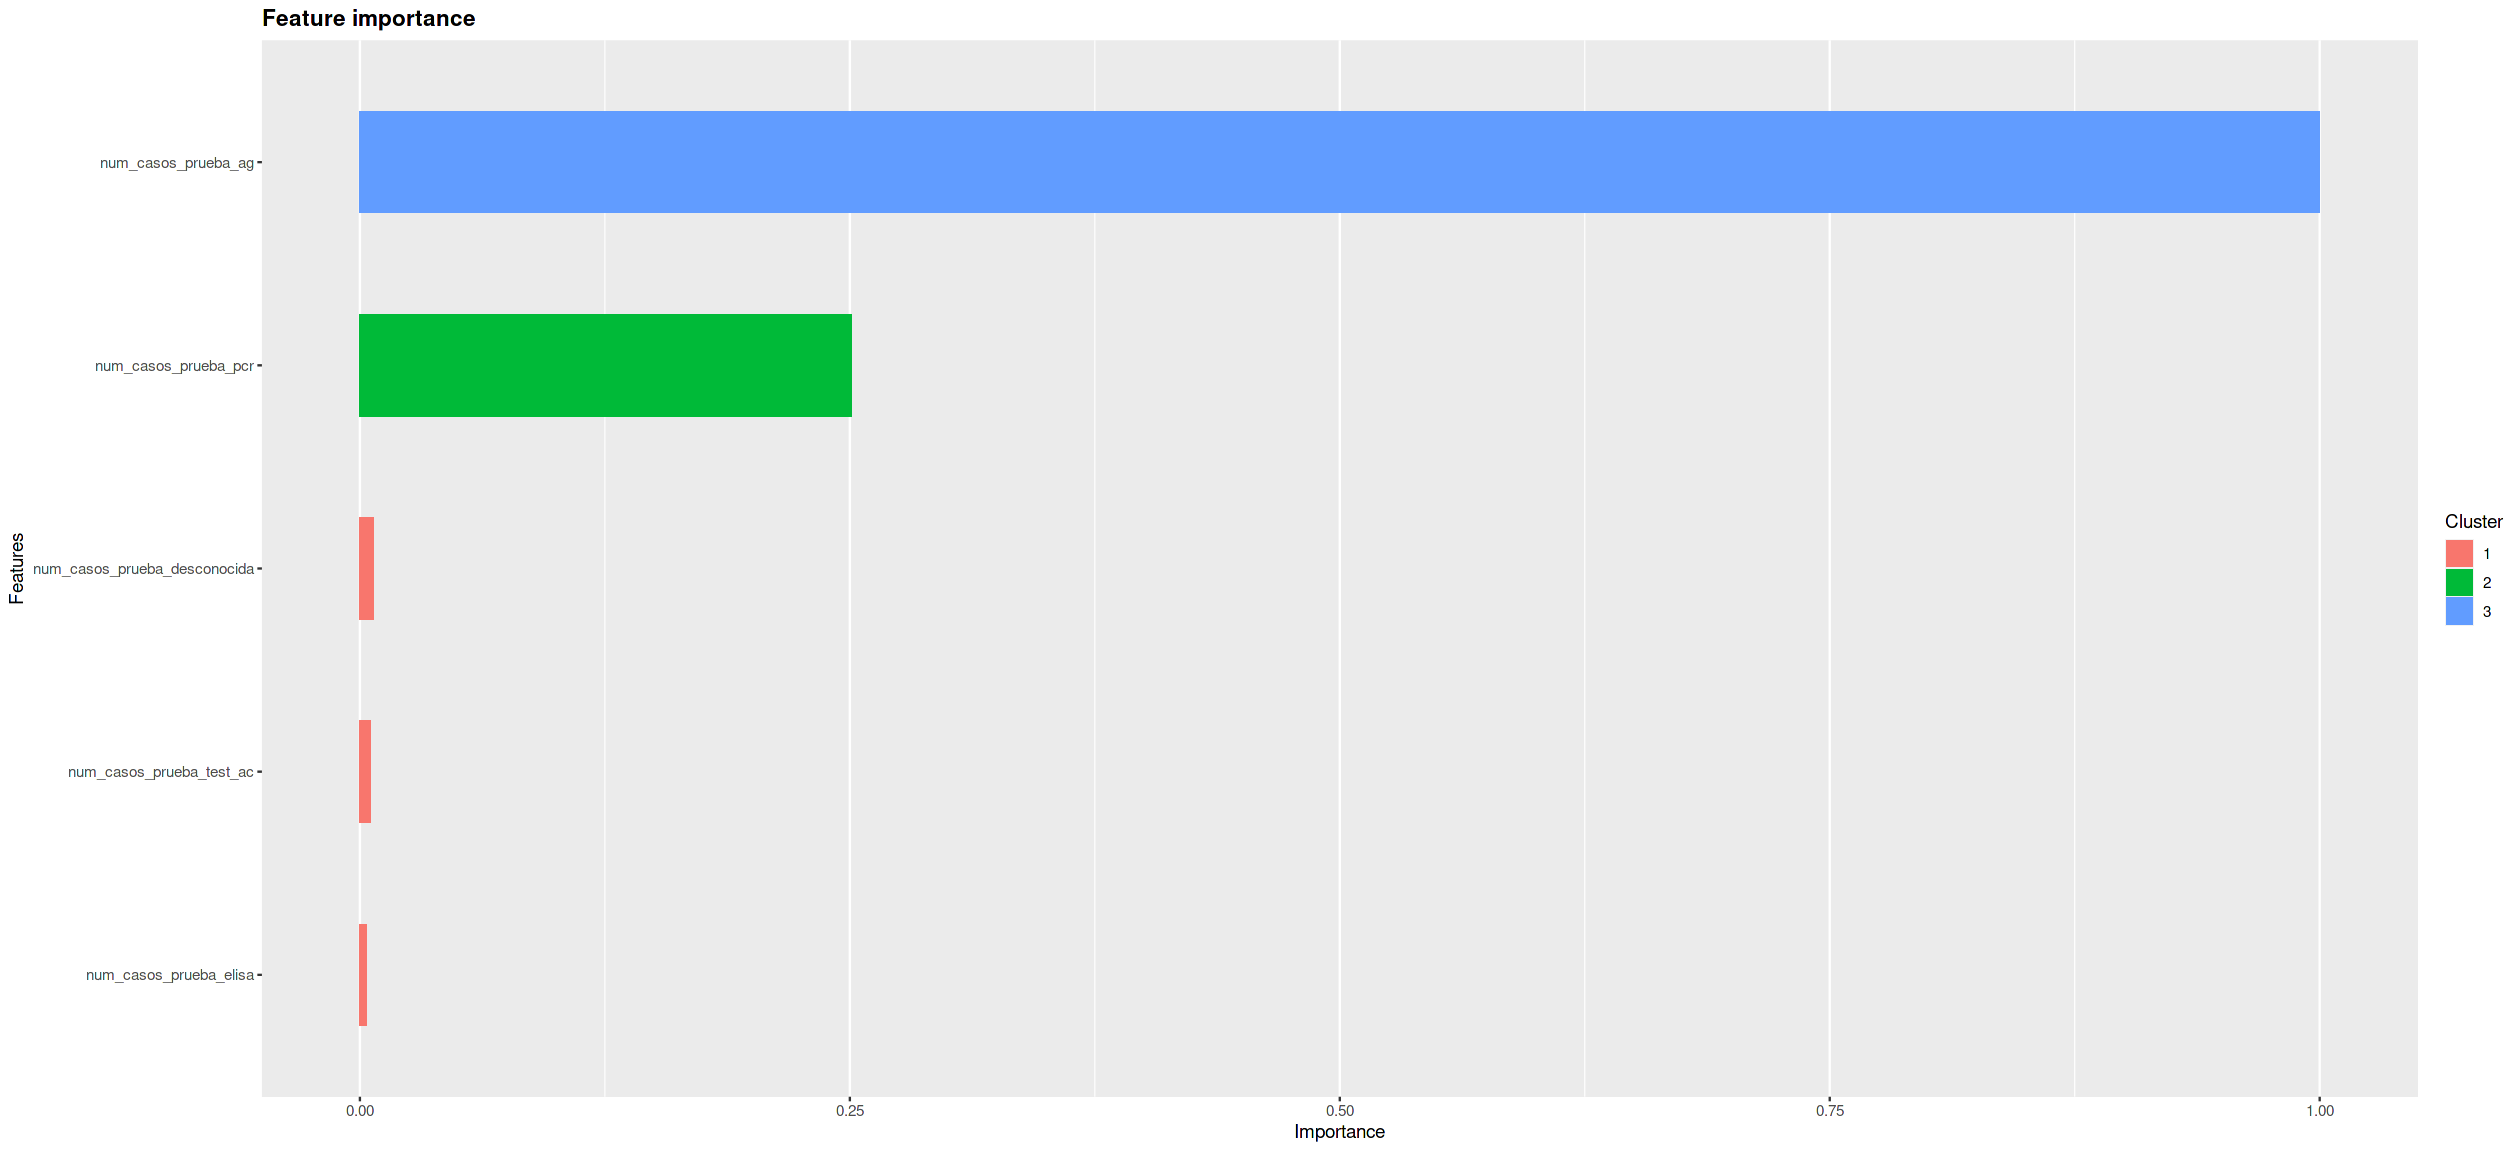

In [73]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_sp_grouped %>% select(-date, -cases_sp)),
    model = xgb_model_sp_grouped$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

<h3 style= "color:red">No Agrupados</h3>

In [74]:
train_Dmatrix <- train_sp %>%
    select(-provincia, -date, -cases_sp, -cod_ine) %>%
    as.matrix() %>%
    xgb.DMatrix()

pred_Dmatrix <- test_sp %>%
    select(-provincia, -date, -cases_sp, -cod_ine) %>%
    as.matrix() %>%
    xgb.DMatrix()

targets <- train_sp$cases_sp

In [75]:
tic()
xgb_model_sp <- caret::train(
    train_Dmatrix,
    targets,
    trControl = xgb_tr_control,
    tuneGrid = xgb_grid,
    method = "xgbTree",
    nthread = 4
)
toc()

117.229 sec elapsed


In [76]:
xgb_model_sp$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
303,200,20,0.02,0,1,1,1


In [77]:
preds <- caret::predict.train(xgb_model_sp, pred_Dmatrix)
test_sp$Preds <- preds
df_spain <- bind_rows(train_sp, test_sp)

Warning message:
“Removed 24305 rows containing missing values (position_stack).”


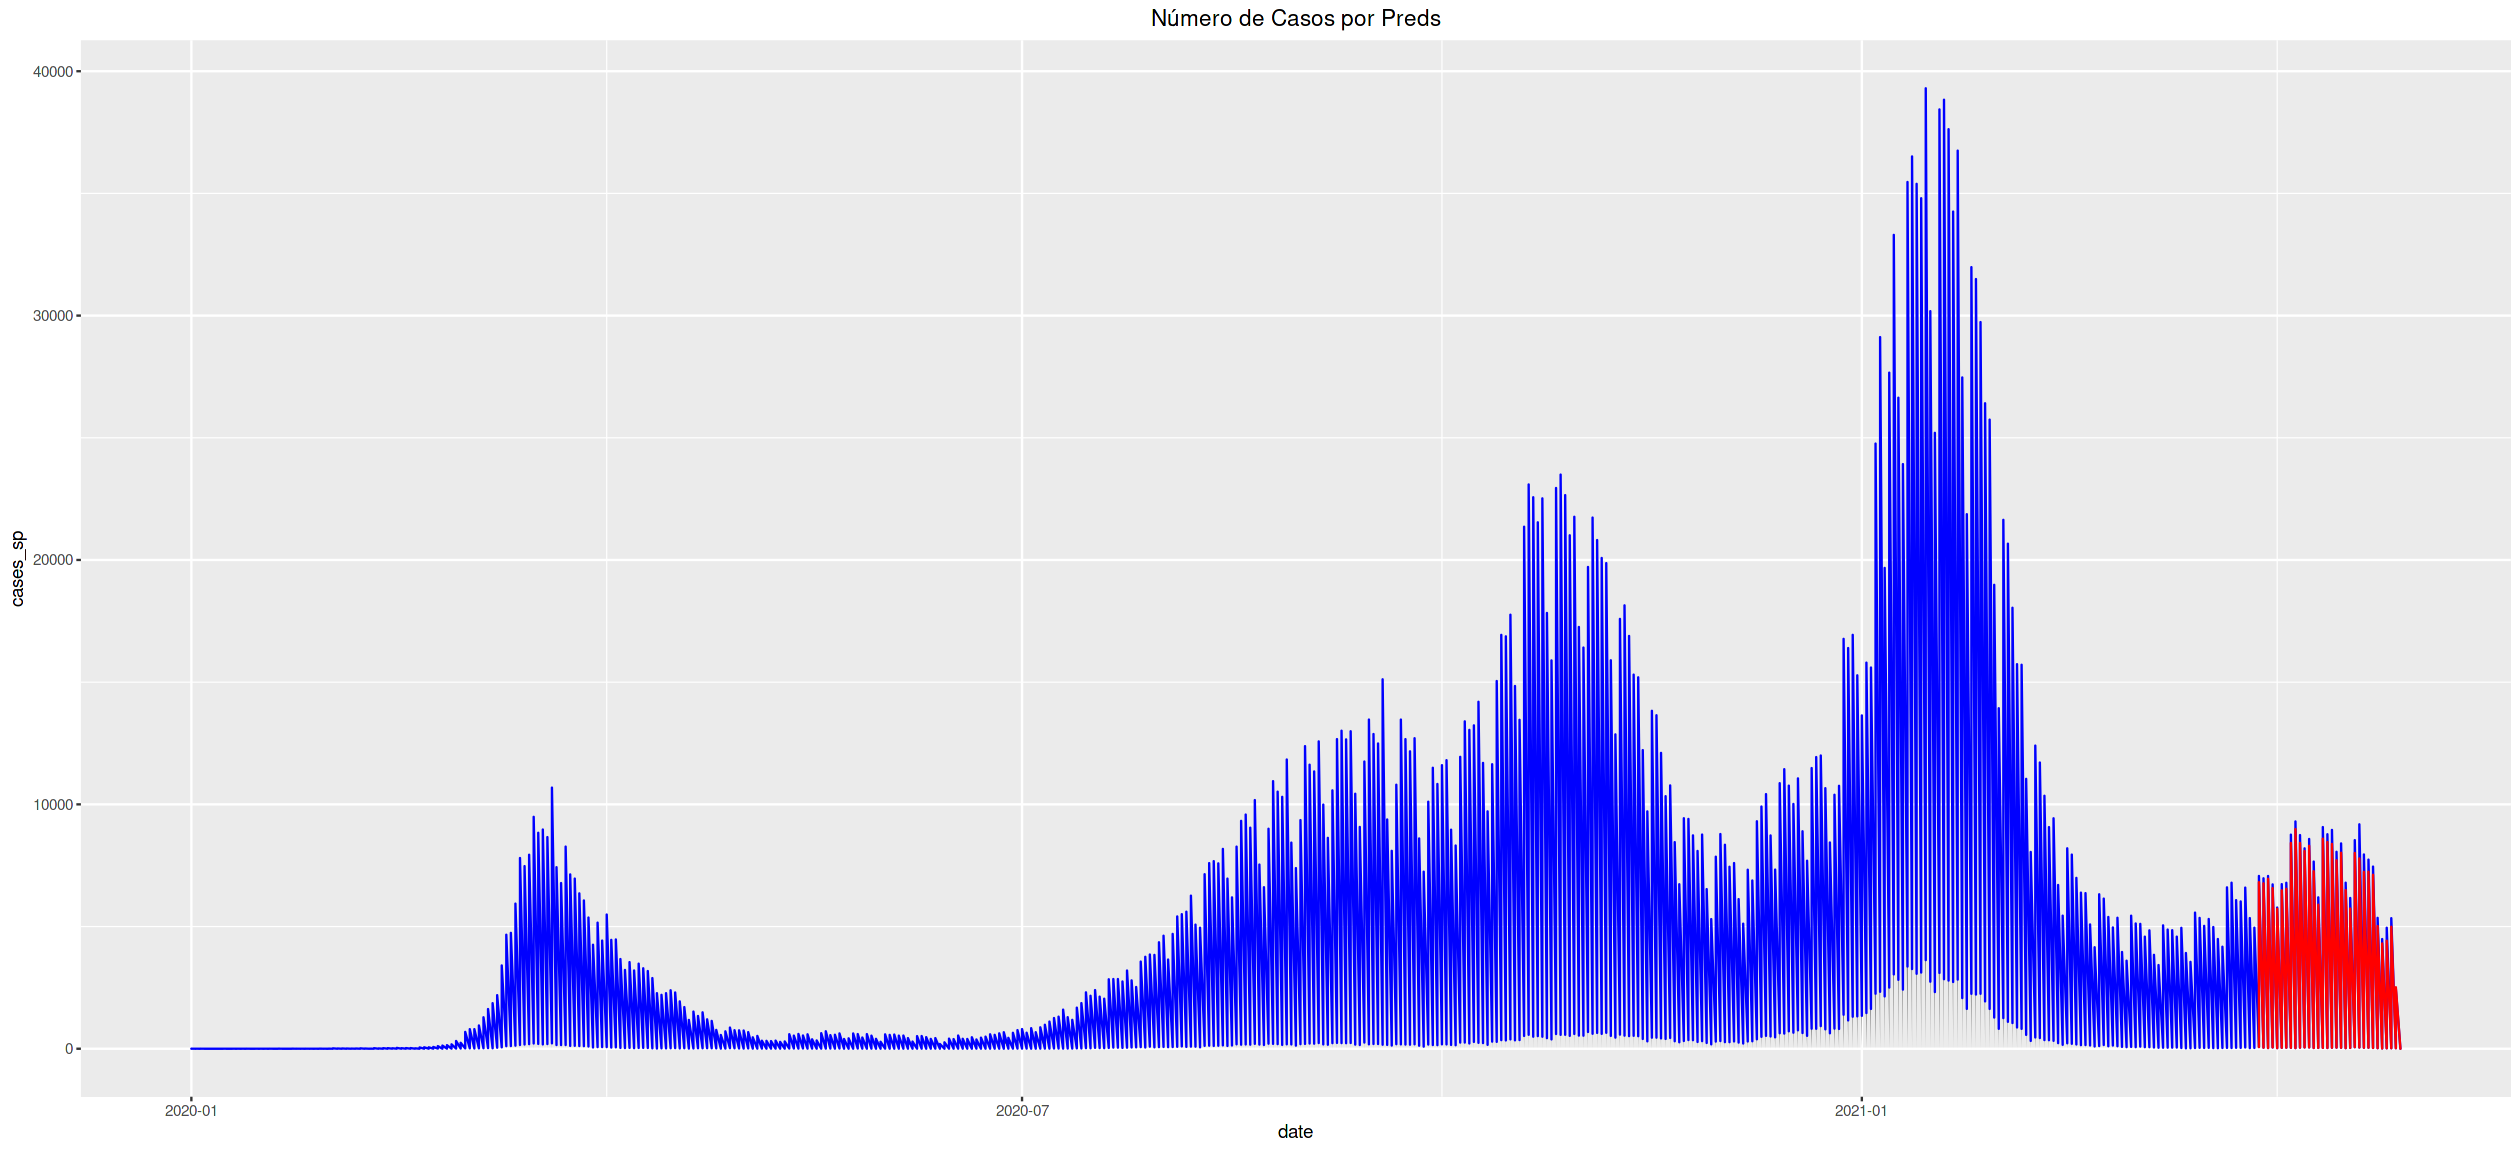

In [78]:
quick_viz_res_area(df_spain, "cases_sp")

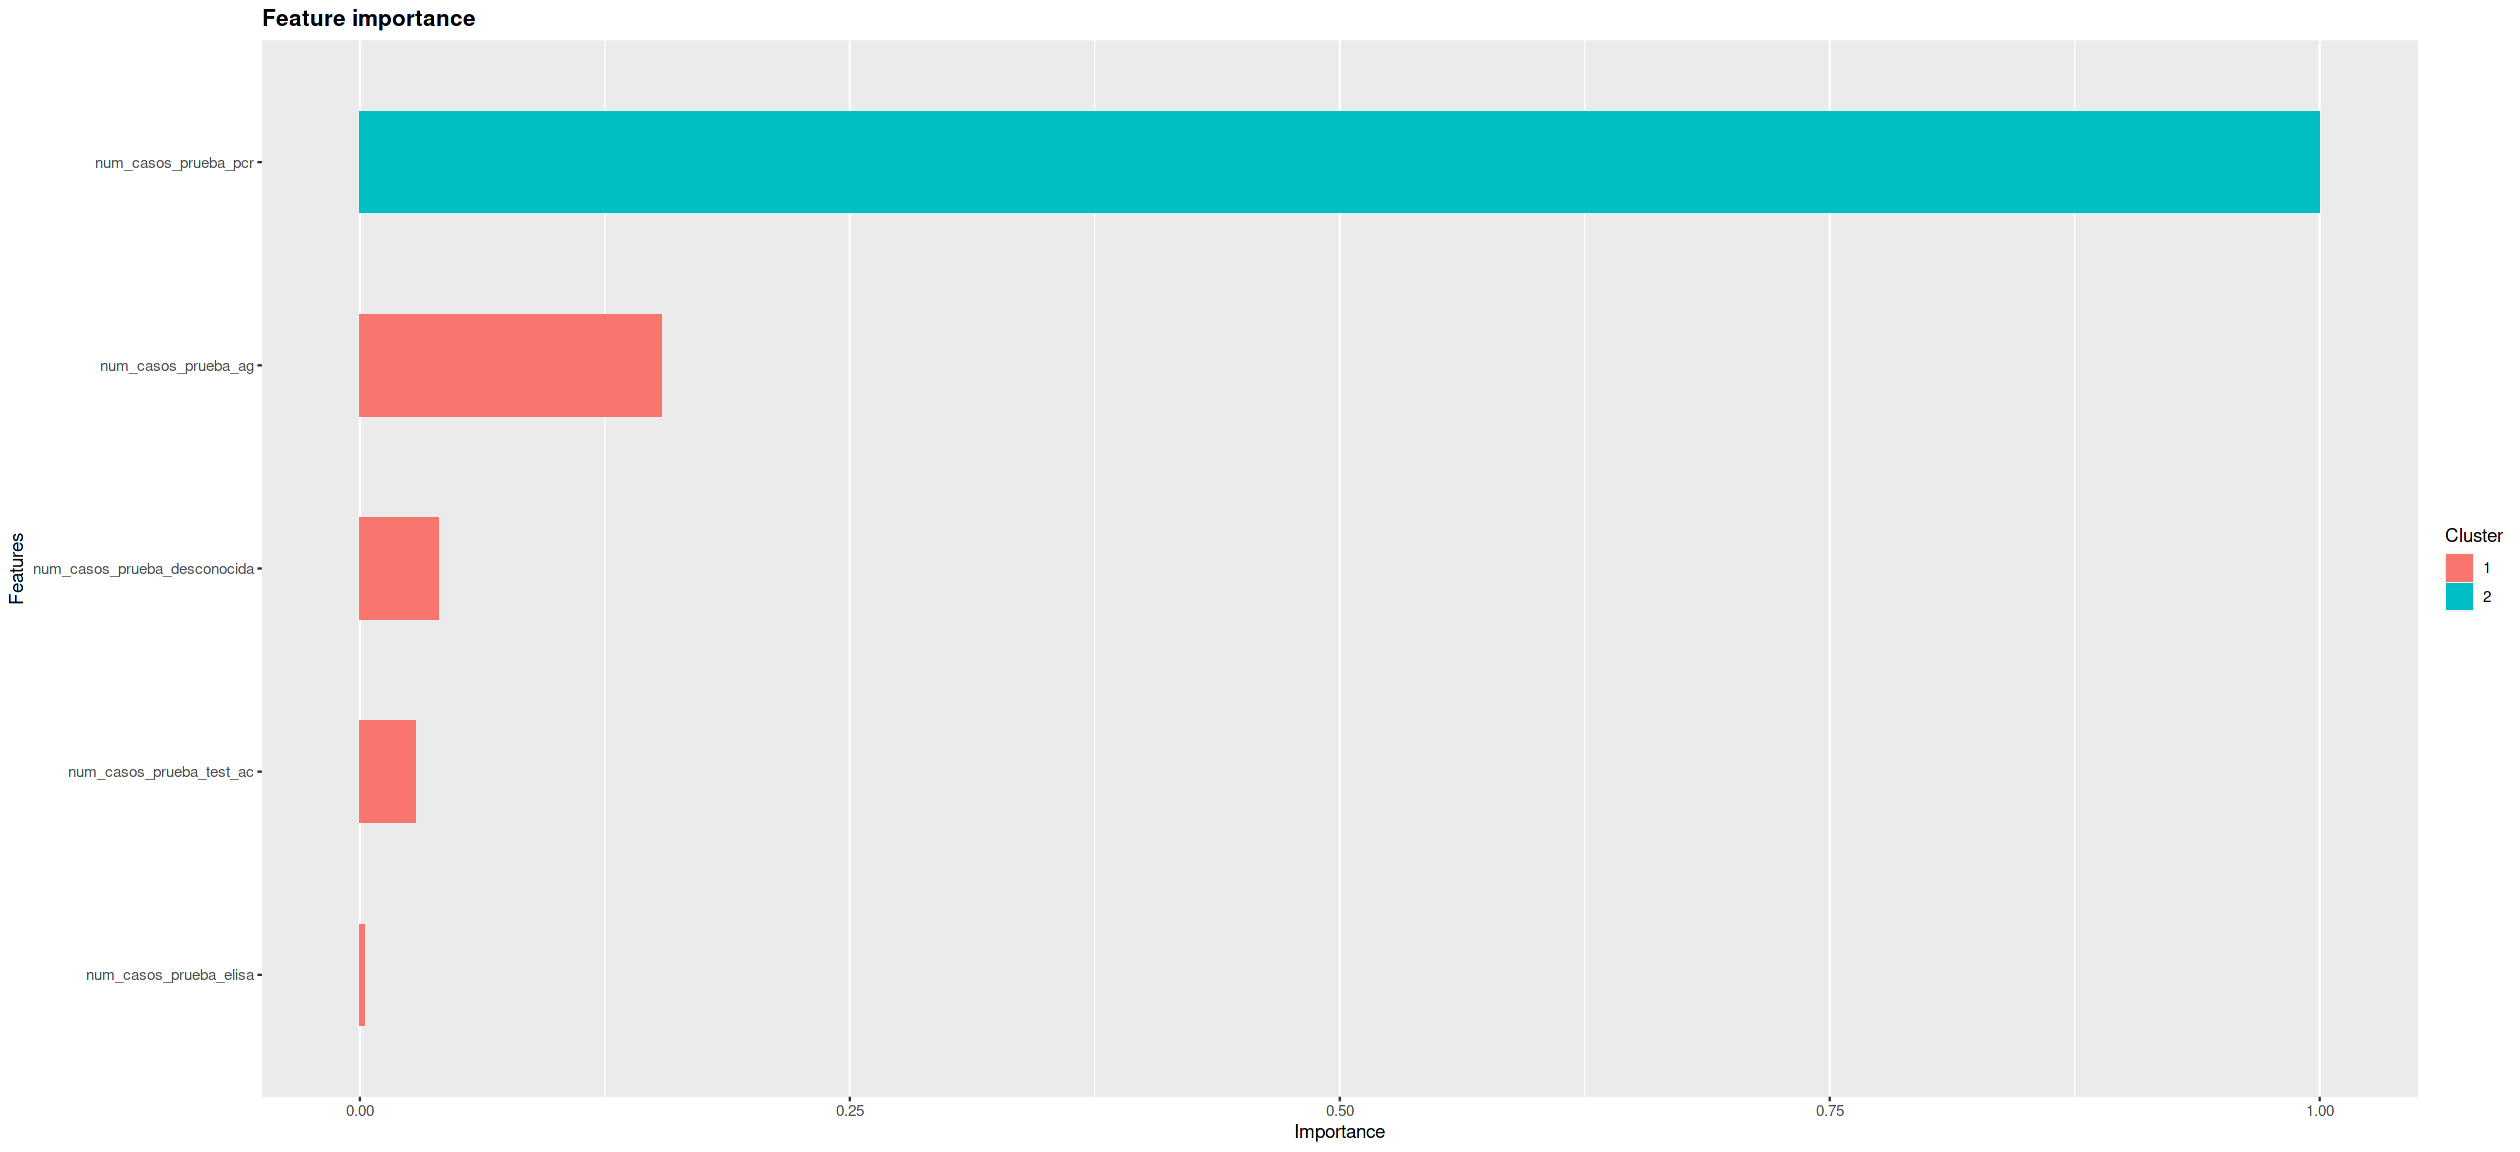

In [79]:
xgb_imp <- xgb.importance(
    feature_names = colnames(train_sp %>% select(-provincia, -date, -cases_sp, -cod_ine)),
    model = xgb_model_sp$finalModel
)
xgb.ggplot.importance(xgb_imp, rel_to_first = T)

# Recursos
- https://www.kaggle.com/fanconic/covid-19-additional-statistics
- https://www.kaggle.com/kaniya/covid-global-forecast-sir-xgboost
- https://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html
- https://cran.r-project.org/web/packages/forecastML/vignettes/grouped_forecast.html

In [80]:
#countries <- fread("../input/covid19-data/Global_Mobility_Report.csv", stringsAsFactors = F)

#fig <- plot_ly(
#    countries, 
#    type = "choropleth", 
#    locations = countries$country_region_code,
#    z = countries$retail_and_recreation_percent_change_from_baseline,
#    colorscale = "Viridis"
#)
#fig